# *special* tutorial

Written by: *Valentin Christiaens*.

Last update: *2022/06/09*

This jupyter notebook tutorial is available in the ``special-extras`` [repository](https://github.com/VChristiaens/special_extras). 
Alternatively, you can execute this repository on [Binder](https://mybinder.org/v2/gh/VChristiaens/special_extras/main) (in the tutorials directory).

## Table of contents

* [1. Loading the data](#1.-Loading-the-data)

* [2. Spectral correlation matrix](#2.-Spectral-correlation-matrix)
    - [2.1 Estimating the spectral correlation between IFS channels](#2.1-Estimating-the-spectral-correlation-between-IFS-channels)
    - [2.2 Concatenating spectral correlation matrices](#2.2-Concatenating-spectral-correlation-matrices)

* [3. Preliminary spectral analysis](#3.-Preliminary-spectral-analysis)
    - [3.1 Dereddening](#3.1-Dereddening)
    - [3.2 Spectral indices](#3.2-Spectral-indices)
    
* [4. MCMC sampler examples](#4.-MCMC-sampler-examples)
    - [4.1. Parameters](#4.1.-Parameters)
    - [4.2. Blackbody model](#4.2.-Blackbody-model)
    - [4.3. BT-SETTL model](#4.3.-BT-SETTL-model)
    - [4.4. BT-SETTL + BB model](#4.4.-BT-SETTL-+-BB-model)
    - [4.5. BT-SETTL + BrG line model](#4.5.-BT-SETTL-+-BrG-line-model)
    
* [5. Comparison of results](#5.-Comparison-of-results)
    - [5.1. Akaike Information Criterion](#5.1.-Akaike-Information-Criterion)
    - [5.2. Best-fit models](#5.2.-Best-fit-models)
    - [5.3. Models from the posterior distribution](#5.3.-Models-from-the-posterior-distribution)

* [6. Nested sampler examples](#6.-Nested-sampler-examples)
    - [6.1. Nestle - single ellipsoid method](#6.1.-Nestle---single-ellipsoid-method)
    - [6.2. Nestle - multi-ellipsoid method](#6.2.-Nestle---multi-ellipsoid-method)
    - [6.3. UltraNest](#6.3.-UltraNest)
* [7. Best-fit template spectrum](#7.-Best-fit-template-spectrum)

-----------

In [1]:
import special
special.__version__

'0.1.2'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# 1. Loading the data

In the 'dataset' folder of the `special_extras` repository you can find:

- a post-processed Integral Field Spectrograph (IFS) datacube (`CrA-9_2019_IFS_pca_annulus.fits`);
- the measured spectrum of (sub)stellar companion CrA-9 b/B (`CrA-9b_spectrum.fits`).

Let's define our input path:

In [3]:
import os
path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
datpath = path+'/datasets/'

In the post-processed IFS cube, the emission from the central star has been modeled and subtracted using the ADI strategy in each spectral channel. The post-processing was performed using principal component analysis (PCA) applied in a single annulus. The annulus was chosen to encompass the faint (sub)stellar companion CrA-9b/B, which can be seen towards the left of the images.

Let's first inspect the IFS cube using the `info_fits` utility implemented in the `fits` module:

In [4]:
from special.fits import info_fits
info_fits(datpath+'CrA-9_2019_IFS_pca_annulus.fits')

Filename: /Users/valentin/GitHub/special_extras/datasets/CrA-9_2019_IFS_pca_annulus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (291, 291, 39)   float64   


The fits file contains an IFS datacube of 39 images with wavelengths spanning 0.95 to 1.68 $\mu$m.
Each image is 291x291 px across. Let's now open it and check a few spectral channels.

In [5]:
from special.fits import open_fits
ifs_cube = open_fits(datpath+'CrA-9_2019_IFS_pca_annulus.fits')

Fits HDU-0 data successfully loaded. Data shape: (39, 291, 291)


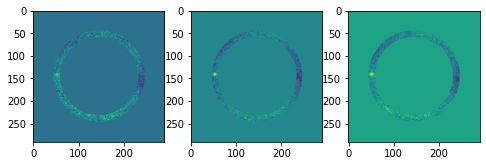

In [6]:
from special.config import figsize
fig, axes = plt.subplots(1,3,figsize=figsize)
axes[0].imshow(ifs_cube[1])
axes[1].imshow(ifs_cube[19])
axes[2].imshow(ifs_cube[-1])

A point source can be seen towards the left of the image. This is CrA-9 b/B, a faint companion to the pre-main sequence star CrA-9, whose nature is still debated (Christiaens et al. 2021). In addition to this IFS datacube obtained with VLT instrument SPHERE/IFS, three additional detections of the companion were obtained with VLT imagers SPHERE/IRDIS at 2.11 $\mu$m and 2.25$\mu$m, and NACO at 3.8 $\mu$m. The full measured spectrum contains thus 42 points: 

In [7]:
info_fits(datpath+'CrA-9b_spectrum.fits')

Filename: /Users/valentin/GitHub/special_extras/datasets/CrA-9b_spectrum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (42, 4)   float32   


The 4 dimensions correspond to:

- the wavelength of each measurement (in $\mu$m); 
- the channel width (or FWHM of the broad band filter used in the case or IRDIS and NACO);
- the flux of the companion;
- the error on the flux.

In [8]:
spectrum_b = open_fits(datpath+'CrA-9b_spectrum.fits')

lbda = spectrum_b[0]
dlbda = spectrum_b[1]
spec = spectrum_b[2]
spec_err = spectrum_b[3]

Fits HDU-0 data successfully loaded. Data shape: (4, 42)


The flux units follow the SI convention (W m$^{-2}$). Let's set it for later. Note that `special` can also handle 'cgs' and 'jy'. The relevant conversions will be made internally if units are provided for observed and model spectra. If not specified, `special` assumes SI units.

In [9]:
units_obs = 'si'

Let's visualize the measured spectrum in $\lambda F_{\lambda}$ units:

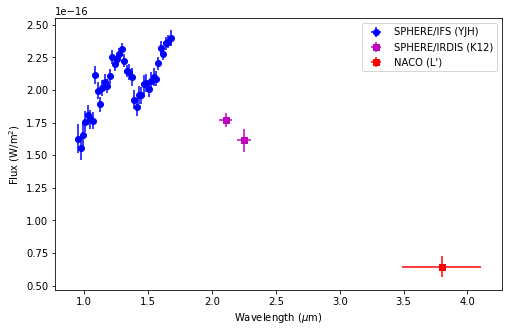

In [10]:
fig = plt.figure(figsize=figsize)
plt.errorbar(lbda[:-3], lbda[:-3]*spec[:-3], lbda[:-3]*spec_err[:-3], dlbda[:-3], 'bo', 
             label = 'SPHERE/IFS (YJH)')
plt.errorbar(lbda[-3:-1], lbda[-3:-1]*spec[-3:-1], lbda[-3:-1]*spec_err[-3:-1], dlbda[-3:-1], 'ms', 
             label = 'SPHERE/IRDIS (K12)')
plt.errorbar(lbda[-1], lbda[-1]*spec[-1], lbda[-1]*spec_err[-1], dlbda[-1], 'rs', 
             label = "NACO (L')")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

[Go to the top](#Table-of-contents)

# 2. Spectral correlation matrix

## 2.1 Estimating the spectral correlation between IFS channels

Before fitting different models to the spectrum, let's first estimate the spectral correlation between the IFS channels. By design of the IFS, the flux at a given wavelength leaks on/overlaps with neighbouring channels. These can therefore not be considered as independent measurements. The spectral correlation matrix has therefore to be considered when fitting a given IFS spectrum. Not taking it into account can indeed lead to significant biases, and in particular to erroneous results in terms of best-fit model parameters (see e.g. [Greco & Brandt 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...833..134G/abstract)). 

Estimating the spectral correlation can be done easily in `special` using the `spectral_correlation` routine, which follows the method recommended in [Greco & Brandt 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...833..134G/abstract). For that let's first determine the location of the companion in the IFS images, by zooming on the median image of the cube:

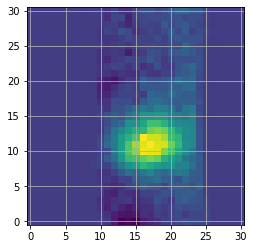

In [11]:
x_i = 35
y_i = 130
sz = 31
plt.imshow(np.median(ifs_cube,axis=0)[y_i:y_i+sz,x_i:x_i+sz])
plt.gca().invert_yaxis()
plt.grid()

Based on the above inset, we can set the approximate coordinates of the companion, and infer its radial separation:

In [12]:
pl_xy = ((x_i+17,y_i+11),) # set pl_xy as a tuple of 2-element tuples - each tuple corresponds to a different companion

cy = (ifs_cube.shape[1]/2.)-0.5
cx = (ifs_cube.shape[2]/2.)-0.5
r0 = np.sqrt((pl_xy[0][0]-cx)**2+(pl_xy[0][1]-cy)**2)
r0

93.08598175880189

The spectral correlation depends on the radial separation to the central star. The algorithm implemented in `special` can therefore compute it in concentric annuli between given inner and outer radii (by default spanning the whole field). Here since we are only interested in the spectral correlation at the radial separation of the companion, let's set the annular width, inner and outer radii such that they only encompass the companion radial separation:


In [13]:
awidth=2
r_in = int(r0-awidth/2)
r_out = int(r0+awidth/2)

Furthermore, we mask the area around the companion to not bias the spectral correlation estimate with companion flux. We set the mask radius to be 4 times the FWHM, with a FWHM set to 4px:


In [14]:
mask_r=4
fwhm=4

Now, we can estimate the spectral correlation at the radial separation of CrA-9b/B:

In [15]:
from special.spec_corr import spectral_correlation
sp_corr = spectral_correlation(ifs_cube, awidth=awidth, r_in=r_in, r_out=r_out, pl_xy=pl_xy, 
                               mask_r=mask_r, fwhm=fwhm)
sp_corr = sp_corr[0]

Let's visualize it:

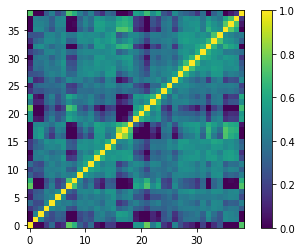

In [16]:
plt.imshow(sp_corr)
plt.colorbar()
plt.gca().invert_yaxis()

Here we used a high number of principal components for PCA, and the companion is far away from the star, such that the correlated speckle noise is efficiently subtracted from each reduced channel. Consequently, not much correlation can be seen between channels. Each spectral channel is most correlated to itself, and at most to its 2 closest neighbouring channels. Note that zero is adopted for uncorrelated channels.

## 2.2 Concatenating spectral correlation matrices

Since our full spectrum of CrA-9b/B also contains photometric points measured by SPHERE/IRDIS (2) and NACO (1), we need to pad the IFS spectral correlation matrix with 3 additional rows and columns of zeroes + ones on the diagonal, in order to get the final spectral correlation matrix.

This can easily be done with the `combine_spec_corrs` routine:

In [17]:
from special.spec_corr import combine_spec_corrs

n_ird=2
n_naco=1
arr_list = [sp_corr]+[1]*n_ird+[1]*n_naco

final_sp_corr = combine_spec_corrs(arr_list)

Let's visualize the final matrix:

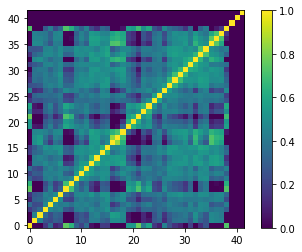

In [18]:
plt.imshow(final_sp_corr)
plt.colorbar()
plt.gca().invert_yaxis()

Uncomment the lines in the following box if you wish to save the final spectral correlation matrix in fits format.

In [19]:
#from special.fits import write_fits
#write_fits(datpath+"CrA-9_sp_corr_matrix.fits", final_sp_corr)

[Go to the top](#Table-of-contents)

# 3. Preliminary spectral analysis

A number of utilities are implemented in the `utils_spec` module, which allow for a preliminary qualitative analysis of the spectrum of the companion. However, to avoid biased conclusions due to extinction in this preliminary analysis, let's first deredden the observed spectrum using the value quoted in the literature for CrA-9 ($A_V = 1.6$ mag; Dunham et a. 2015).

## 3.1 Dereddening

Provided a given $A_V$ extinction value, the `extinction` routine can estimate the corresponding extinction factor at different wavelengths following the Cardelli et al. (1989) law, and for a desired $R_V$ value. Let's consider the standard ISM value of $R_V = 3.1$ mag (default if not provided).

In [20]:
from special.utils_spec import extinction
AV_est = 1.6 #mag
A_lambda = extinction(lbda, AV_est, RV=3.1)
extinc_fac = np.power(10,-A_lambda/2.5)

Let's plot the extinction factor as a function of wavelength:

Text(0, 0.5, 'Extinction factor')

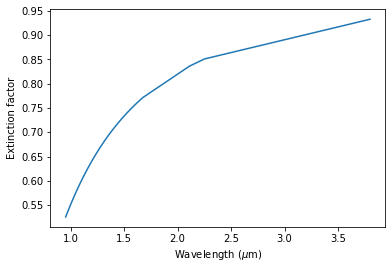

In [21]:
plt.plot(lbda, extinc_fac)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Extinction factor")

We see that as expected the effect of extinction is stronger at shorter NIR wavelengths: at 1.0 $\mu$m roughly only half of the flux is transmitted, while at $L'$ band (3.8 $\mu$m) $\sim$ 93\% of the flux is transmitted.

Let's now deredden the spectrum accordingly and plot it:

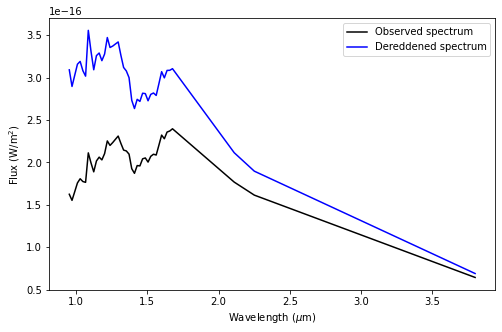

In [22]:
spec_dered = spec/extinc_fac
spec_dered_err = spec_err/extinc_fac

fig = plt.figure(figsize=figsize)
plt.plot(lbda, lbda*spec, 'k', label="Observed spectrum")
plt.plot(lbda, lbda*spec_dered, 'b', label="Dereddened spectrum")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

## 3.2 Spectral indices

(Sub)stellar objects of M, L and T types have been extensively studied. Some empirical spectral indices have been proposed to estimate either their spectral type or their gravity type from the measured flux in two parts of their spectrum. Some of these spectral indices have been included in `special` (additional inputs are welcome). An example is provided below with the H$_2$O and Na indices which are relevant for a $YJH$ spectrum.

It is important to note that different spectral indices are valid in different spectral subtype ranges! The interested reader is referred to the following works: Allers et al. (2007); Bonnefoy et al. (2014) and references therein.

In [23]:
from special.spec_indices import spectral_idx

H2O_idx = spectral_idx(lbda, spec_dered, 'H2O-1.5', spec_dered_err, verbose=True)
Na_idx = spectral_idx(lbda, spec_dered, 'Na-1.1', spec_dered_err, verbose=True)
        
print("***********************")
print("H2O index: {:.3f}+-{:.3f}".format(H2O_idx[0],H2O_idx[1]))
print("Na index: {:.3f}+-{:.3f}".format(Na_idx[0],Na_idx[1]))
print("***********************")

Closest (non-overlapping) wavelengths to 1.550, 1.560, 1.492 and 1.502 mu correspond to 1.544, 1.563, 1.486 and 1.506 mu resp.
*WARNING*: spectral resolution is barely sufficient for non-overlapping indices - results to be taken with caution!
Closest (non-overlapping) wavelengths to 1.150, 1.160, 1.134 and 1.144 mu correspond to 1.163, 1.163, 1.124 and 1.144 mu resp.
***********************
H2O index: 0.975+-0.007
Na index: 1.011+-0.004
***********************


The H$_2$O index can then be converted to an estimated spectral type:

In [24]:
from special.spec_indices import sp_idx_to_spt, digit_to_spt

spt, spt_err = sp_idx_to_spt(H2O_idx[0], 'H2O-1.5', H2O_idx[1])
spt_str = digit_to_spt(spt, convention='Allers07')
print("SpT: {}+-{:.1f}".format(spt_str, spt_err))

SpT: M5.1+-0.8


The Na index on the other hand can be used to provide a qualitative estimate on the gravity (hence the youth) of an object:

In [25]:
from special.spec_indices import sp_idx_to_gravity

sp_idx_to_gravity(Na_idx, name='Na-1.1')

The object's gravity is consistent with being very young (Na index less than 1.4; Allers et al. 2007))


[Go to the top](#Table-of-contents)

# 4. MCMC sampler examples

Now let's fit different models to the observed spectrum of CrA-9 b/B.

In that purpose, let's first define some parameters that will be common to all MCMC sampler runs on this measured spectrum.

## 4.1. Parameters

Let's first define the distance to the system, which will be used to scale the models (along with the companion radius):

In [26]:
d_st = 153. #pc based on Gaia

The internal workings of `special` allow for the convolution with the spectral PSF of (in the case of an IFS), or the integration over a filter transmission curve (in the case of photometric points). For these options to be considered, let's provide the nominal spectral FWHM in nm for IFS (19.15 nm), and the name of the filenames where the filter transmission curves are encoded. 

In [27]:
instru_res = [34.5, 'SPHERE_IRDIS_D_K1.dat', 'SPHERE_IRDIS_D_K2.dat', 'CONICA_L_prime.dat']

Now let's assign an index to each instrument and build a list that will tell the algorithm which `instru_res` values are to be assigned to which datapoints.

In [28]:
n_ifs=39
instru_idx = np.array(n_ifs*[1]+[2]+[3]+[4])  

In addition, we define a snippet function that can read the filter transmissions mentioned in the list. For convenience (and to allow for multiprocessing), it is defined in `utils.py`, and commented below FYI.

In [29]:
from utils import filter_reader

# import pandas as pd
# def filter_reader(filename):
#     # snippet to read filter files and return a tuple: lbda (mu), transmission
#     path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
#     filter_path = path+"/static/filters/"
#     filt_table = pd.read_csv(filter_path+filename, sep=' ', header=0, 
#                              skipinitialspace=True)
#     keys = filt_table.keys()
#     lbda_filt = np.array(filt_table[keys[0]])
#     if lbda_filt.dtype == 'O':
#         filt_table = pd.read_csv(filter_path+filename, sep='\t', header=0, 
#                                  skipinitialspace=True)
#         keys = filt_table.keys()
#         lbda_filt = np.array(filt_table[keys[0]])
#     elif lbda_filt.dtype == 'int32' or lbda_filt.dtype == 'int64': 
#         lbda_filt = np.array(filt_table[keys[0]], dtype='float64')
#     if '(AA)' in keys[0]:
#         lbda_filt /=10000
#     elif '(mu)' in keys[0]:
#         pass
#     elif '(nm)' in keys[0]:
#         lbda_filt /=1000
#     else:
#         raise ValueError('Wavelength unit not recognised in filter file')
#     trans = np.array(filt_table[keys[1]])
#     return lbda_filt, trans

Let's assemble all parameters related to the instrument(s) and filter(s) into a dictionary, including as well the spectral correlation calculated in Sec. 2:

In [30]:
instru_params = {'instru_res':instru_res,
                 'instru_idx':instru_idx,
                 'instru_corr': final_sp_corr,
                 'filter_reader': filter_reader}

`special` was implemented with directly imaged substellar objects in mind. Radii and masses therefore implicitly assume Jovian units. If you prefer Solar radii for your outputs, set `star` to True in the following box:

In [31]:
from astropy import constants as c

star = False # whether use Solar units
if star:
    conv_RS = c.R_jup/c.R_sun
    conv_RS

Let's set the MCMC parameters identically for all runs shown in the next subsections (see more details in `emcee` documentation):

In [32]:
a=2.0
nwalkers=100
niteration_min=100
niteration_limit=500 # recommended>> 1000
nproc = 2            # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Similarly, we adopt the autocorrelation time criterion for convergence for all MCMC runs (see more details [here](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)):

In [33]:
conv_test='ac'
ac_c=50
ac_count_thr=1

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr':ac_count_thr}

Note that for the purpose of this tutorial, we set a low number of walkers and a low maximum number of iterations. It is recommended to set it large enough (>>1000, depends on number of parameters and model) such that the convergence criterion will break the chain once it is met.

## 4.2. Blackbody model

This model does not involve any grid:

In [34]:
grid_list=None # triggers a blackbody fit

The 2 parameters are the temperature and radius (of a sphere). It is important to label the blackbody temperature and radius 'Tbb1' and 'Rbb1', respectively. This is because `special` allows for the addition of an unlimited number of blackbody components. E.g. for n components, set the labels from 'Tbb1' to 'Tbbn' and from 'Rbb1' to 'Rbbn'. 

In [35]:
labels = ('Tbb1', 'Rbb1')
units = ('K', r'$R_J$')

npar = len(labels)

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [36]:
ini_guess = (3200., 1.3) #K and R_Jup
bounds = {'Tbb1':(2000,4000), 
          'Rbb1':(0.1,5)}

Again, let's collate all model-related parameters into a dictionary:

In [37]:
model_params={'grid_param_list':grid_list,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [38]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, units_obs=units_obs,
                         **instru_params, **mcmc_params, **conv_params, **model_params)

Let's convert the sampled radii into Solar radii (if requested):

In [39]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('Rbb1')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

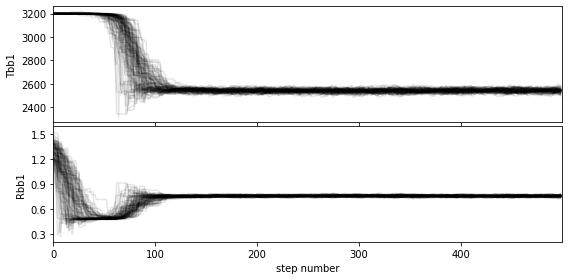

In [40]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.3 and apply it to the chain:

In [41]:
burnin=0.3

In [42]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BB = final_chain[:, cutoff:, :].reshape((-1,npar)) 
#write_fits(output_dir+"isamples_flat.fits",isamples_flat)

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Tbb1: 68.72857142857143%
percentage for Rbb1: 69.55142857142857%
******* Results for Tbb1 ***** 


Confidence intervals:
Tbb1: 2537.7400493630957 [-12.792700205536221,17.24233505963548]
******* Results for Rbb1 ***** 


Confidence intervals:
Rbb1: 0.7611845929296133 [-0.0093733577473053,0.009373357747305189]


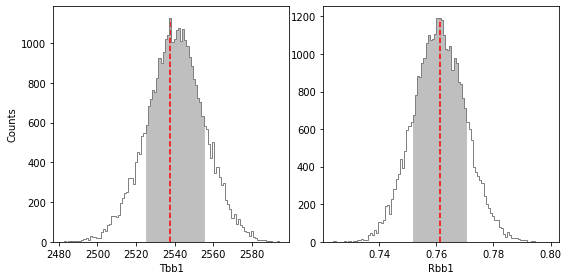

In [43]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BB, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [44]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [45]:
ndig = (0,2) # should have same length as labels
labels_plot = (r'$T$', r'$R$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

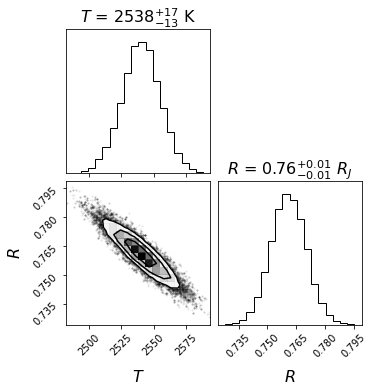

In [46]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

As expected, the 2 parameters are highly dependent on each other. With only 2 parameters, we also note that the estimated uncertainties on each parameter are very small. As we will see, with a more realistic model including more parameters, the uncertainties on each parameter get wider.

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [47]:
# favoured model has highest likelihood
max_prob_BB = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BB = final_chain[idx_max]
bf_params_BB

array([2.53977904e+03, 7.61103568e-01])

## 4.3. BT-SETTL model

Let's now consider a grid of BT-SETTL models. In addition, let's also consider extinction as a free parameter, since for young objects it is possible that different amounts of dust surround the companion than the central star.

In the case of BT-SETTL models, there are 2 free parameters in the grid: effective temperature and surface gravity. Let's define the grid of parameter values covered by the models in our possession (in the `models/btsettl15/` directory).

In [48]:
teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Let's now define a snippet function that can read the input files of the grid, and provide as output a tuple of 2 vectors (1d arrays) for the wavelength and flux (in SI units, at the surface of the object). For convenience (and to allow for multiprocessing), it is defined in `utils.py`, and commented below FYI.

In [49]:
from utils import bts_reader
# def bts_reader(params):
#     # snippet to read BT-SETTL fits files and return a tuple: lbda (mu), spec (SI)
#     mod_units = 'cgs' # careful: input in cgs
#     path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
#     mod_path = path+'/static/btsettl15_models/'
#     filename = mod_path+'btsettl15_t{:.0f}_g{:.1f}0_z-0.00_SPEX-PRISM.txt'.format(params[0],params[1])        
#     lbda = []
#     flux = []
#     f=open(filename,"r")
#     lines=f.readlines()
#     for i, x in enumerate(lines):
#         if i>0:
#             lbda.append(float(x.split('\t')[0]))
#             flux.append(float(x.split('\t')[1]))
#     f.close() 
    
#     # Correct for atmospheric refraction
#     flux = np.array(flux) 
#     lbda = np.array(lbda)
#     nref = nrefrac(lbda*1e4)
#     lbda = lbda/(1+(nref*1e-6))
    
#     #conversion from ergs/s/cm2/um to W/m2/um
#     flux = convert_F_units(flux, lbda, in_unit=mod_units, out_unit='si') 
    
#     return lbda, flux

Since the snippet function already performs the conversion to SI flux units (W m$^{-2}$), we will the model units to 'si'. Note that 'cgs' units or 'jy' are also accepted - the conversion to match the observed flux would then be made internally.

In [50]:
units_mod = 'si'

Considering also the extinction `A_V` as a free parameter, we have a total of 4 free parameters, including 2 captured by the grid:

The 2 parameters are the temperature and radius (of a sphere). It is important to label the blackbody temperature and radius 'Tbb1' and 'Rbb1', respectively. This is because `special` allows for the addition of an unlimited number of blackbody components. E.g. for n components, set the labels from 'Tbb1' to 'Tbbn' and from 'Rbb1' to 'Rbbn'. 

In [51]:
labels = ('Teff', 'logg', 'R', 'Av')
units = ('K', '', r'$R_J$', 'mag')

npar = len(labels)

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [52]:
ini_guess = (3100., 3.5, 1.3, 1.6)
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5)}

In [53]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'units_mod':units_mod}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [54]:
grid_name = 'bts_resamp_grid.fits' 
output_dir = path+'/static/bts_output/'
resamp_before=True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. differente `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [55]:
output_file = 'MCMC_results' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [56]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, 
                                      **instru_params, **mcmc_params, **conv_params,
                                      **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)


In [57]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

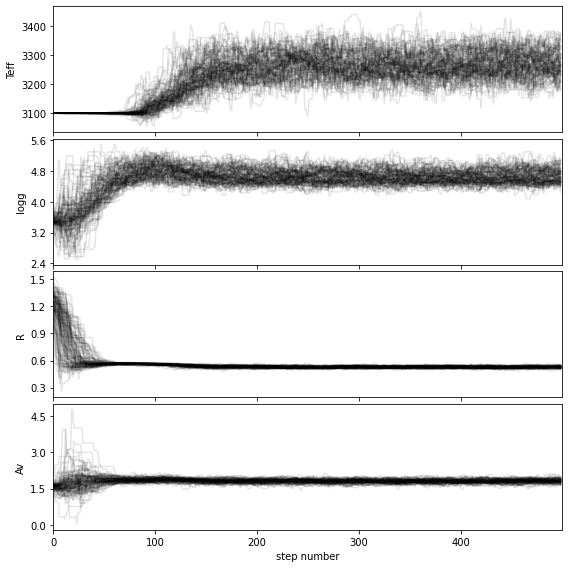

In [58]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.3 and apply it to the chain:

In [59]:
burnin=0.3

In [60]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BTS = final_chain[:, cutoff:, :].reshape((-1,npar)) 
#write_fits(output_dir+"isamples_flat.fits",isamples_flat)

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 69.50285714285714%
percentage for logg: 69.94000000000003%
percentage for R: 69.45428571428572%
percentage for Av: 69.20857142857142%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3250.786950363903 [-37.35389427426344,58.69897671669969]
******* Results for logg ***** 


Confidence intervals:
logg: 4.50766009803268 [-0.07043724567424547,0.32657268448968146]
******* Results for R ***** 


Confidence intervals:
R: 0.5303496899941924 [-0.014883690882466882,0.009780711151335386]
******* Results for Av ***** 


Confidence intervals:
Av: 1.7968786311798544 [-0.06570945637997183,0.09337659590838099]


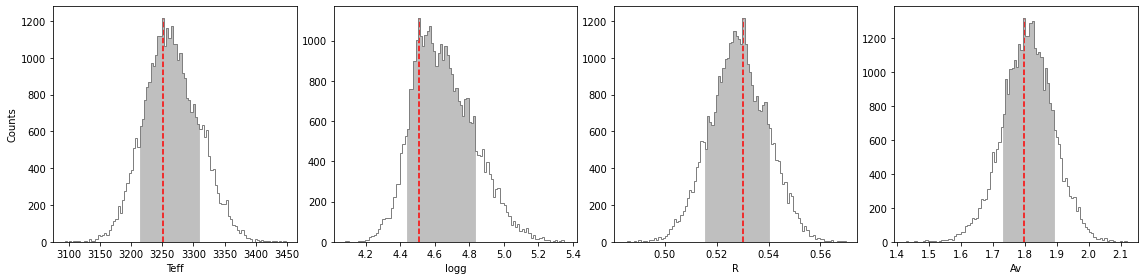

In [61]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BTS, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [62]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [63]:
ndig = (0,1,2,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

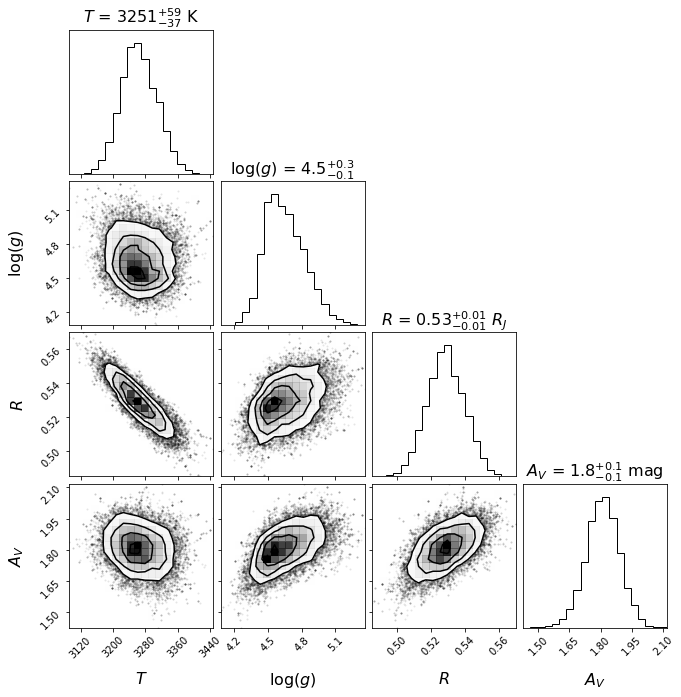

In [64]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [65]:
# favoured model has highest likelihood
max_prob_BTS = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS = final_chain[idx_max]
bf_params_BTS

array([3.27438395e+03, 4.53069471e+00, 5.24606418e-01, 1.78571833e+00])

The results above are puzzling: a ~3000 K effective temperature combined with a ~0.5 $R_J$ photometric radius. See Christiaens et al. (2021) for a discussion on the different hypotheses put forward to reconcile these results.

## 4.4. BT-SETTL + BB model

Although this is not necessarily a good model for the NIR spectrum of CrA-9 B/b, let's illustrate how to set up a photospheric + extra blackbody component model to further showcase the possibilities available in `special`.

Let's set Gaussian priors on the temperatures of each Blackbody component, to replicate the kinds of constraints that could potentially be obtained from past works.

Note that a single extra BB component is considered here, but `special` does not limit the number of components you wish to incorporate in the model (just add the desired number of parameters 'Tbb*n*' and 'Rbb*n*', where *n*>0).

This time, we have a total of 8 free parameters, including 2 captured by the BT-SETTL grid:

In [66]:
labels = ('Teff', 'logg', 'R', 'Av', 'Tbb1', 'Rbb1')
units = ('K', '', r'$R_J$', 'mag', 'K', r'$R_J$')
npar = len(labels)

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [67]:
ini_guess = (3100., 3.5, 1.3, 1.6, 1100, 1)
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5),
          'Tbb1':(900,2000),
          'Rbb1':(0.1,5)}

Let's set Gaussian priors for log($g$), $T_{bb1}$ and $T_{bb2}$ in a dictionary. By default, uniform priors are considered for parameters not mentioned in this dictionary. Be sure to use the same dictionary labels as for parameter `labels`.

In [68]:
priors = {'logg':(3.5,0.2),
          'Tbb1':(1200,200)}

When including a blackbody component, you can ensure that the sampled solutions are physical (e.g. the BB temperatures must systematically be lower temperature than the photosphere effective temperature - assuming it comes from surrounding heated dust):

In [69]:
physical=True

It is also possible to tell the model whether to apply the extinction before or after adding the blackbody component, depending on where the dust absorbing the companion signal is to be assumed with respect to the emitting dust. By default, we assume the latter (e.g. interstellar dust).

In [70]:
AV_bef_bb = False

Let's compile all model-related parameters defined above into a dictionary:

In [71]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'priors':priors,
              'units_mod':units_mod,
              'physical':physical,
              'AV_bef_bb':AV_bef_bb}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [72]:
grid_name = 'bts_bb_resamp_grid.fits' 
output_dir = path+'/static/bts_output/'
resamp_before=True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. different `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [73]:
output_file = 'MCMC_results_bb' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Finally, given the larger number of parameters, let's increase the number of iterations and walkers:

In [74]:
a=2.0
nwalkers=200
niteration_min=100
niteration_limit=1000 # recommended>> 1000
nproc = 2             # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [75]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, units_obs=units_obs,
                                      **instru_params, **mcmc_params, **conv_params, **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)


In [76]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

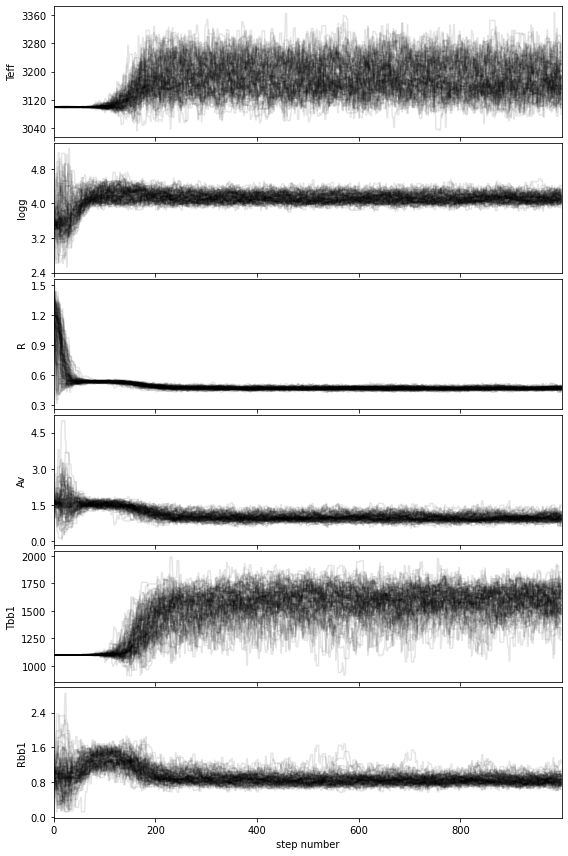

In [77]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.5 and apply it to the chain:

In [78]:
burnin=0.5

In [79]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BTS_BB = final_chain[:, cutoff:, :].reshape((-1,npar))

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 68.503%
percentage for logg: 69.26299999999999%
percentage for R: 69.08899999999998%
percentage for Av: 68.58800000000002%
percentage for Tbb1: 69.62400000000002%
percentage for Rbb1: 69.352%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3179.1785449734407 [-41.65231601788446,51.64887186217675]
******* Results for logg ***** 


Confidence intervals:
logg: 4.097255365739974 [-0.11113489859716541,0.10290268388626522]
******* Results for R ***** 


Confidence intervals:
R: 0.46647988854985856 [-0.011996911701873392,0.015126540841492564]
******* Results for Av ***** 


Confidence intervals:
Av: 0.9517543658581642 [-0.1318767230916329,0.13187672309163267]
******* Results for Tbb1 ***** 


Confidence intervals:
Tbb1: 1608.5978861884005 [-110.943584125082,110.943584125082]
******* Results for Rbb1 ***** 


Confidence intervals:
Rbb1: 0.8197854927372121 [-0.08465402895968444,0.11851564054355834]


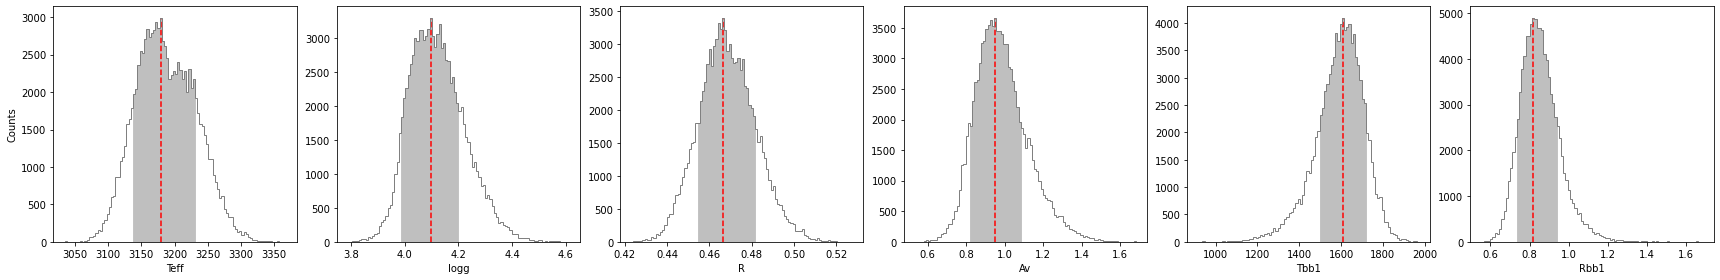

In [80]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BTS_BB, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [81]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [82]:
ndig = (0,1,2,1,0,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$', r'$T_{bb1}$',r'$R_{bb1}$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

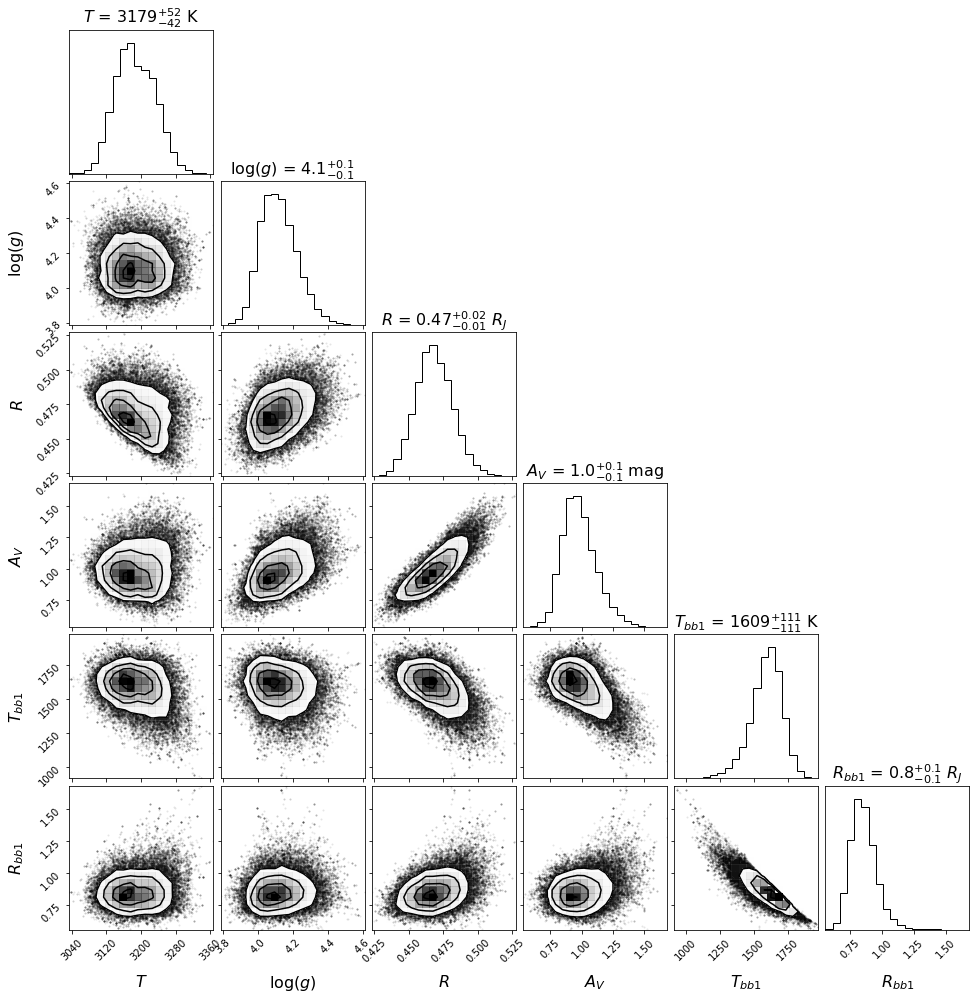

In [83]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [84]:
# favoured model has highest likelihood
max_prob_BTS_BB = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS_BB = final_chain[idx_max]
bf_params_BTS_BB

array([3.15072127e+03, 4.03666853e+00, 4.62826463e-01, 8.81503072e-01,
       1.67077406e+03, 8.20375657e-01])

## 4.5. BT-SETTL model + BrG line model

In order to further showcase the possibilities available in `special`, let's now consider a BT-SETTL + Brackett Gamma line model for the spectrum. Let's also consider $R_V$ as a free parameter, and finally consider Gaussian priors for log($g$) and $R_V$: $\mu_{\mathrm{log}(g)}=3.5$, $\sigma_{\mathrm{log}(g)} = 0.2$ and $\mu_{R_V}=3.1$, $\sigma_{R_V} = 0.2$.  

This time, we have a total of 6 free parameters, including 2 captured by the BT-SETTL grid:

In [85]:
labels = ('Teff', 'logg', 'R', 'Av', 'Rv', 'BrG')
units = ('K', '', r'$R_J$', 'mag', '', '')
npar = len(labels)

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Provide estimate for BrG flux:

In [86]:
import astropy.constants as con
F_BrG_estimate = 20000 # W m-2 at the surface (based on the estimate for the primary)
RB_est = 5             # rough estimate for the radius of the companion in R_J
input_unit = 'LogL'    # select input units {'F','L','LogL'} for Flux (W/m2), Luminosity (W) or Log Solar Luminosity.

Conversion of F_BrG into LSun - do not change:

In [87]:
if input_unit == 'F':
    BrG_min = F_BrG_estimate*1e-5
    BrG_max = F_BrG_estimate*1e5  
elif input_unit == 'LogL':
    # BrG flux is converted below into L_Sun
    L_BrG_estimate = np.log10(4*np.pi*np.power(con.R_jup.value*RB_est,2)*F_BrG_estimate/con.L_sun.value)
    # set min and max of BrG list of initial grid of tested values
    BrG_min = L_BrG_estimate-5
    BrG_max = L_BrG_estimate+5
else:
    BrG_min = F_BrG_estimate*1e-5*4*np.pi*np.power(con.R_jup.value*RB_est,2)
    BrG_max = F_BrG_estimate*1e5*4*np.pi*np.power(con.R_jup.value*RB_est,2)     

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [88]:
# define list of BrG line luminosities
n_BrG_list = 23 # desired number of points in grid
BrG_list = np.linspace(L_BrG_estimate-5, L_BrG_estimate+5, n_BrG_list)
# during MCMC, sampled values will be interpolated from the grid defined above for faster calculation.

ini_guess = (3100., 3.5, 1.3, 1.6, 3.1, np.median(BrG_list))
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5),
          'Rv':(1.,6),
          'BrG': (L_BrG_estimate-5,L_BrG_estimate+5)}

Provide details for each of the line(s). Add an entry in the `em_lines` and `em_grid` dictionaries for each line you'd like to include in the model. Lines can be included in the model without necessarily fitting for their flux with MCMC (e.g. for a known emission line luminosity to be included in the model):

In [89]:
em_lines = {}
em_lines['BrG'] = (2.1667, input_unit, None) # WL, unit and flux (if known). Flux can be None if to be sampled by MCMC.

em_grid = {}
em_grid['BrG'] = BrG_list.copy()

Let's set Gaussian priors for $R_V$ in a dictionary. By default, uniform priors are considered for parameters not mentioned in this dictionary. Be sure to use the same dictionary labels as for parameter `labels`.

In [90]:
priors = {'logg':(3.5,0.2),
          'Rv':(3.1,0.2)}

Let's compile all model-related parameters defined above into a dictionary:

In [91]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'em_lines':em_lines,
              'em_grid':em_grid,
              'priors':priors,
              'units_mod':units_mod}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [92]:
grid_name = 'bts_BrG_resamp_grid.fits' 
output_dir = path + '/static/bts_output/'
resamp_before = True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. different `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [93]:
output_file = 'MCMC_results_BrG' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Finally, given the larger number of parameters, let's increase the number of iterations and walkers:

In [94]:
a=2.0
nwalkers=250
niteration_min=100
niteration_limit=1500 # recommended>> 1000
nproc = 2             # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [95]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params, 
                         **mcmc_params, **conv_params, **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 23, 42, 2)


In [96]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

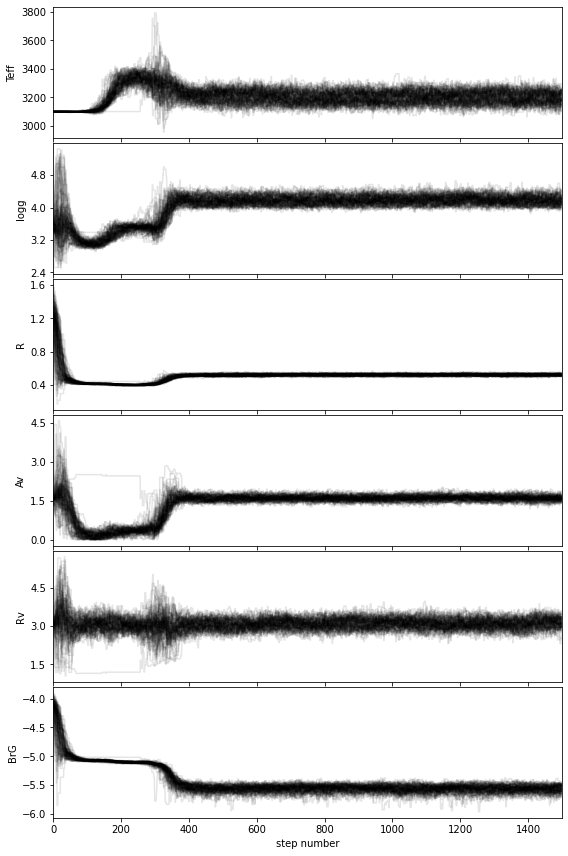

In [97]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.5 and apply it to the chain:

In [98]:
burnin=0.5

In [99]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BrG = final_chain[:, cutoff:, :].reshape((-1,npar)) 

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 69.86613333333334%
percentage for logg: 69.70826666666667%
percentage for R: 68.62613333333334%
percentage for Av: 68.70186666666666%
percentage for Rv: 68.7968%
percentage for BrG: 68.54880000000001%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3221.711222998054 [-65.97953035499677,25.37674244422942]
******* Results for logg ***** 


Confidence intervals:
logg: 4.162225733747001 [-0.1095830485100393,0.12581757421522966]
******* Results for R ***** 


Confidence intervals:
R: 0.515982354099404 [-0.00882138340708083,0.015321350128087552]
******* Results for Av ***** 


Confidence intervals:
Av: 1.6103090027556652 [-0.10675311698303758,0.0974702372453824]
******* Results for Rv ***** 


Confidence intervals:
Rv: 3.090109364986358 [-0.22459530381301418,0.206627679507974]
******* Results for BrG ***** 


Confidence intervals:
BrG: -5.5345416458961365 [-0.08169321020093534,0.04248046930448712]


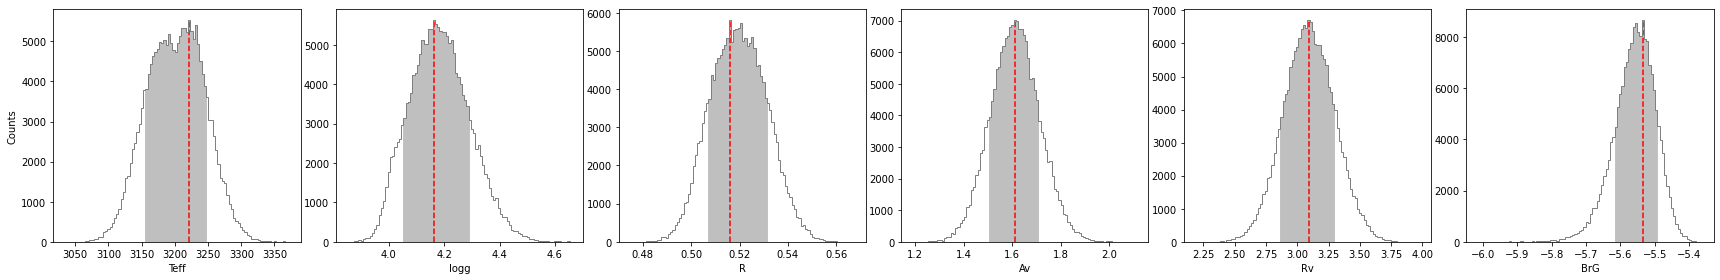

In [100]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BrG, labels, cfd=68.27, bins=bins, gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [101]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [102]:
ndig = (0,1,2,1,1,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$',  r'$R_V$', r"$\log(\frac{L_{\rm BrG}}{L_{\odot}})$")
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

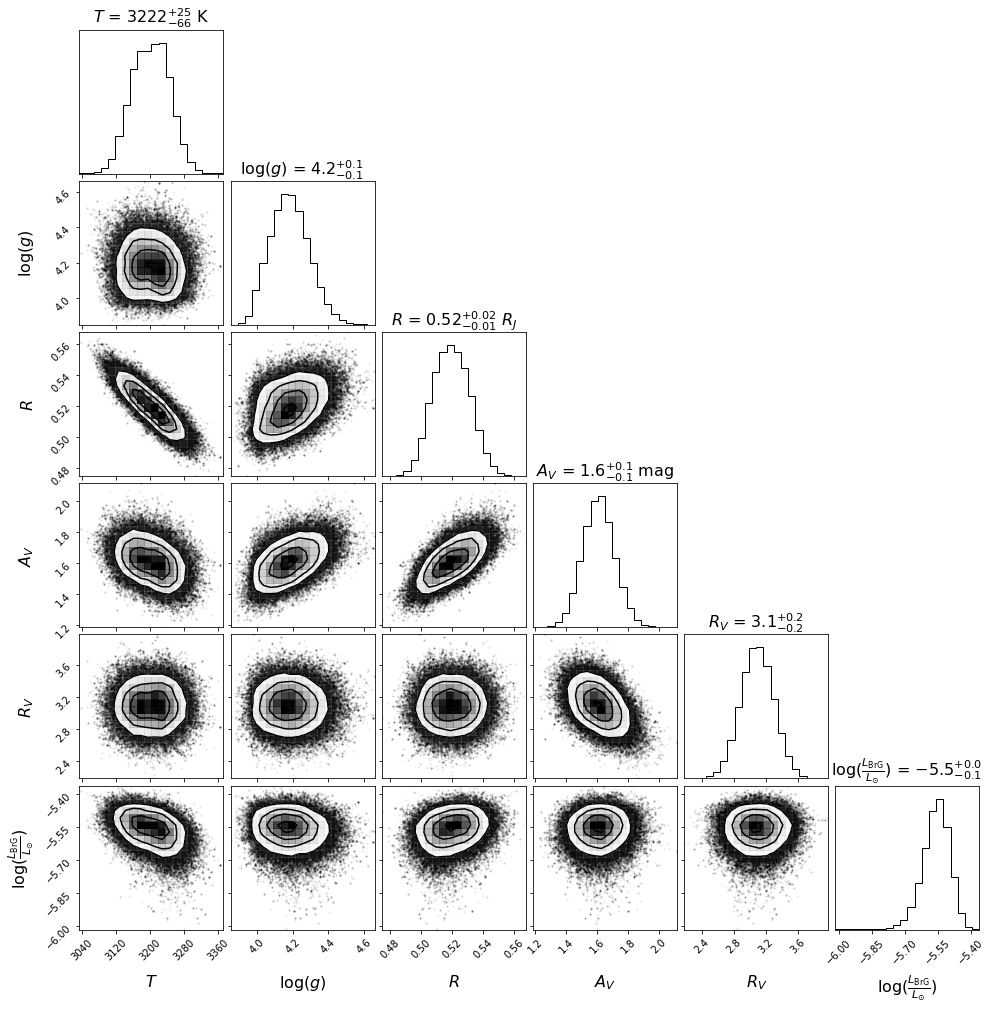

In [103]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Compared to the results obtained without the inclusion of a potential BrG line (affecting the K1 photometry of the point source), we now get a lower value of log(g), more consistent with a young object. Nonetheless, the required BrG line luminosity is significant. This would likely imply the presence of more H recombination lines - which may or may not be present near ~1.09 and ~1.22 $\mu$m (see below).

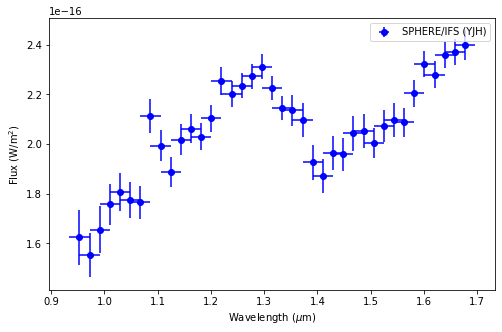

In [104]:
fig = plt.figure(figsize=figsize)
plt.errorbar(lbda[:-3], lbda[:-3]*spec[:-3], lbda[:-3]*spec_err[:-3], dlbda[:-3], 'bo', 
             label = 'SPHERE/IFS (YJH)')
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [105]:
# favoured model has highest likelihood
max_prob_BTS_BrG = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS_BrG = final_chain[idx_max]
bf_params_BTS_BrG

array([ 3.21297292e+03,  4.15539197e+00,  5.15276653e-01,  1.57341610e+00,
        3.10480904e+00, -5.54897892e+00])

[Go to the top](#Table-of-contents)

# 5. Comparison of results

## 5.1. Akaike Information Criterion

For each of the tested type of model above (Secs. 4.2 to 4.5), let's compute the Akaike Information Criterion (AIC) in order to assess which one is likely the best model for our observations. The 4 tested models are:

- Blackbody (2 parameters);
- BT-SETTL + extinction (4 parameters);
- BT-SETTL + 2BB + extinction (8 parameters); 
- BT-SETTL + BrG + extinction (6 parameters)

For each type of model, we need the maximum likelihood model among all MCMC samples, and the number of free parameters.

In [106]:
nparam_list = [2, 4, 6, 6]
max_prob_list = [max_prob_BB, max_prob_BTS, max_prob_BTS_BB, max_prob_BTS_BrG]

n_models = len(nparam_list)

In [107]:
from special.utils_spec import akaike

aic_list = [akaike(max_prob_list[i],nparam_list[i]) for i in range(n_models)]
aic_list

[297.15311871426286, 166.63657036898275, 138.76614386979492, 156.7740277722682]

Now let's compute the $\Delta$ AIC, i.e. the difference with the smallest AIC value obtained for the different models:


In [108]:
min_aic = np.amin(aic_list)

daic_list = [aic_list[i]-min_aic for i in range(n_models)]
daic_list

[158.38697484446794, 27.87042649918783, 0.0, 18.00788390247328]

The values above suggest that the most likely types of model that we considered are the BT-SETTL alone, the BT-SETTL+BB and BT-SETTL+BrG line models.

Since the difference is >>10 for the BB model, we can conclude that there is no support for that kind of model (Burnham & Anderson 2002).

[Go to the top](#Table-of-contents)

## 5.2. Best-fit models

Let's first assemble all the relevant parameters from the different models considered above in different lists:

In [109]:
lab_models = ['BB', 'BT-SETTL', 'BT-SETTL + BB', 'BT-SETTL + BrG line']
bf_params = [bf_params_BB, bf_params_BTS, bf_params_BTS_BB, bf_params_BTS_BrG]
all_samples_flat = [samples_flat_BB, samples_flat_BTS, samples_flat_BTS_BB, samples_flat_BrG]
all_labels = [('Tbb1', 'Rbb1'),
              ('Teff', 'logg', 'R', 'Av'),
              ('Teff', 'logg', 'R', 'Av', 'Tbb1', 'Rbb1'),
              ('Teff', 'logg', 'R', 'Av', 'Rv', 'BrG')]
all_grid_lists = [None, grid_list, grid_list, grid_list]
all_em_lines = [{}, {}, {}, em_lines]
all_em_grids = [{}, {}, {}, em_grid]
all_ndig = [(0,2),
            (0,1,2,1),
            (0,1,2,1,0,1),
            (0,1,2,1,1,1)]
all_units = [('K', r'$R_J$'),
             ('K', '', r'$R_J$', 'mag'),
             ('K', '', r'$R_J$', 'mag', 'K', r'$R_J$'),
             ('K', '', r'$R_J$', 'mag', '', '')]

n_models = len(lab_models)

In [110]:
bf_params

[array([2.53977904e+03, 7.61103568e-01]),
 array([3.27438395e+03, 4.53069471e+00, 5.24606418e-01, 1.78571833e+00]),
 array([3.15072127e+03, 4.03666853e+00, 4.62826463e-01, 8.81503072e-01,
        1.67077406e+03, 8.20375657e-01]),
 array([ 3.21297292e+03,  4.15539197e+00,  5.15276653e-01,  1.57341610e+00,
         3.10480904e+00, -5.54897892e+00])]

Now for each type of model considered above, let's now generate the spectrum corresponding to the most likely parameters inferred with the MCMC. 
By providing `lbda_obs` to `make_model_from_params`, the returned model will be resampled to match the spectral resolution of the measured spectrum. If provided, the instrumental spectral FWHM and/or photometric filter(s) will also be used. If `lbda_obs` is left to None, the model is returned at the native resolution of the grid used as input. Let's leverage this to have both high-res and resampled spectra.

In [111]:
from special.model_resampling import make_model_from_params

bf_models = []
bf_models_hr = []

for nn in range(n_models):
    bf_params_nn = tuple(bf_params[nn])
    lbda_model, flux_model = make_model_from_params(bf_params_nn, 
                                                    all_labels[nn], 
                                                    all_grid_lists[nn], 
                                                    d_st, 
                                                    model_reader=bts_reader, 
                                                    em_lines=all_em_lines[nn], 
                                                    em_grid=all_em_grids[nn], 
                                                    units_obs=units_obs, 
                                                    units_mod=units_mod, 
                                                    interp_order=1,
                                                    lbda_obs=lbda,
                                                    dlbda_obs=dlbda,
                                                    instru_res=instru_res, 
                                                    instru_idx=instru_idx, 
                                                    filter_reader=filter_reader)
    bf_models.append([lbda_model, flux_model])
    if nn > 0:
        lbda_model_hr, flux_model_hr = make_model_from_params(bf_params_nn, 
                                                              all_labels[nn], 
                                                              all_grid_lists[nn], 
                                                              d_st, 
                                                              model_reader=bts_reader, 
                                                              em_lines=all_em_lines[nn], 
                                                              em_grid=all_em_grids[nn], 
                                                              units_obs=units_obs, 
                                                              units_mod=units_mod, 
                                                              interp_order=1)
        bf_models_hr.append([lbda_model_hr, flux_model_hr])

For models not based on a grid, `lbda_obs` is a mandatory parameter, hence the avoidance of the BB model for high-res models. Let's use the output `lbda_model_hr` from BT-SETTL models, to add a high-res spectrum for the BB model as well.

In [112]:
lbda_model_hr, flux_model_hr = make_model_from_params(tuple(bf_params[0]), 
                                                      all_labels[0], 
                                                      all_grid_lists[0], 
                                                      d_st, 
                                                      model_reader=bts_reader, 
                                                      em_lines=all_em_lines[0], 
                                                      em_grid=all_em_grids[0], 
                                                      units_obs=units_obs, 
                                                      units_mod=units_mod, 
                                                      interp_order=1,
                                                      lbda_obs=bf_models_hr[-1][0])
bf_models_hr = [[lbda_model_hr, flux_model_hr]]+bf_models_hr

Now crop the model spectra to the same wavelength range as the measured spectrum:

In [113]:
from special.utils_spec import find_nearest

for nn in range(n_models):
    lbda_model_hr, flux_model_hr = bf_models_hr[nn]
    # LOAD BEST FIT MODEL
    idx_ini = find_nearest(lbda_model_hr,0.99*lbda[0], constraint='floor')
    idx_fin = find_nearest(lbda_model_hr,1.01*lbda[-1], constraint='ceil')
    lbda_model_hr = lbda_model_hr[idx_ini:idx_fin+1]
    flux_model_hr = flux_model_hr[idx_ini:idx_fin+1]
    dlbda_hr = np.mean(lbda_model_hr[1:]-lbda_model_hr[:-1])
    bf_models_hr[nn] = [lbda_model_hr, flux_model_hr]

Now let's plot the best-fit models at their native resolution (first panel) and after resampling (second panel):

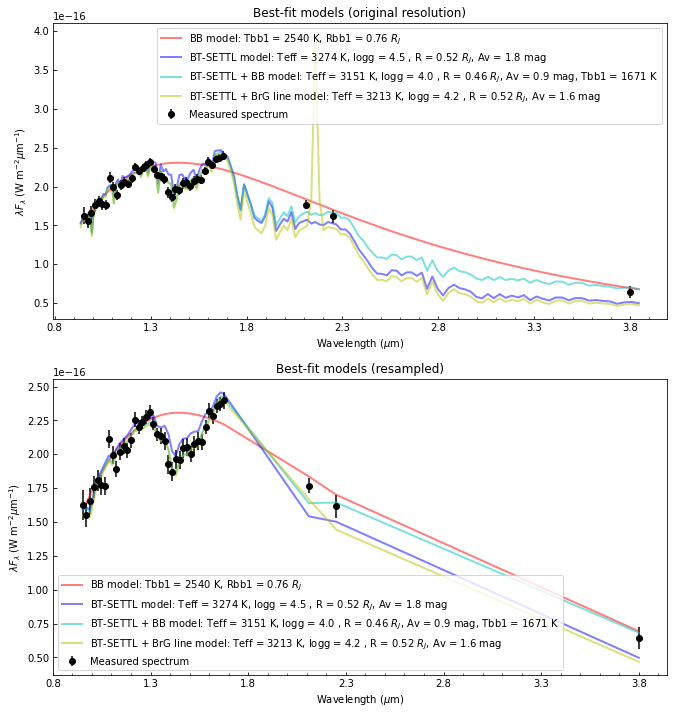

In [114]:
fig, axes = plt.subplots(2,1,figsize=(11,12))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Titles
axes[0].set_title("Best-fit models (original resolution)")
axes[1].set_title("Best-fit models (resampled)")

# Plot measured spectrum
axes[0].errorbar(lbda, lbda*spec, 
             lbda*spec_err, fmt=cols[0]+'o', 
             label='Measured spectrum')
axes[1].errorbar(lbda, lbda*spec, 
             lbda*spec_err, fmt=cols[0]+'o', 
             label='Measured spectrum')

# Set axes labels
axes[0].set_xlabel(r"Wavelength ($\mu$m)")
axes[0].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")
axes[1].set_xlabel(r"Wavelength ($\mu$m)")
axes[1].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")

# Plot best-fit models
for i in range(2):
    if i == 0:
        bf_models_i = bf_models_hr
    else:
        bf_models_i = bf_models
    for nn in range(n_models):
        lbda_model, flux_model = bf_models_i[nn]

        lab_str = '{0} = {1:.{2}f} {3}'
        if nn==0 or nn ==1:
            show_labs = range(len(bf_params[nn]))
        elif nn==2:
            show_labs = range(len(bf_params[nn])-1)
        else:
            show_labs = list(range(len(bf_params[nn])-2))
        lab_str_list = [lab_str.format(all_labels[nn][j], bf_params[nn][j], all_ndig[nn][j], all_units[nn][j]) for j in show_labs]
        sep = ', '
        label = "{} model: {}".format(lab_models[nn], sep.join(lab_str_list))
        axes[i].plot(lbda_model, lbda_model*flux_model, cols[1+nn], linewidth=2,
                 alpha=0.5, label=label)

        min_tick = lbda[0]-dlbda[0]/2-((lbda[0]-dlbda[0]/2)%0.2)
        max_tick = lbda[-1]+dlbda[-1]/2+(0.2-((lbda[-1]+dlbda[-1]/2)%0.2))
        major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
        minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

        axes[i].set_xticks(major_ticks1)
        axes[i].set_xticks(minor_ticks1, minor = True)
        axes[i].tick_params(which = 'both', direction = 'in')
        axes[i].legend(loc='best')    

plt.show()

[Go to the top](#Table-of-contents)

## 5.3. Models from the posterior distribution

It can be useful to plot a large number of models randomly picked from the posterior distribution in order to have an idea of the uncertainty in different parts of the spectrum. Let's consider 200 samples from the posterior distribution:

In [115]:
n_samp = 200

In [116]:
import random

all_plot_samples = []
for nn in range(n_models):
    print("################## Model {} ##################".format(lab_models[nn]))
    samp_flux = []
    lbda_samp = None # use native model resolution (set to `lbda` for measured spectrum sampling)
    if nn == 0:
        # set the wavelength sampling for 
        lbda_samp=bf_models_hr[-1][0]
    for ii in range(n_samp):
        # draw a random integer
        idx = random.randint(0, len(all_samples_flat[nn]))
        param_samp = tuple(all_samples_flat[nn][idx])
        samp_lbda, tmp = make_model_from_params(param_samp, all_labels[nn], all_grid_lists[nn], d_st,
                                                model_reader=bts_reader, em_lines=all_em_lines[nn], 
                                                em_grid=all_em_grids[nn], units_obs=units_obs, 
                                                units_mod=units_mod, interp_order=1, lbda_obs=lbda_samp)
        
        samp_flux.append(tmp)
    # Crop to same range as measurements
    idx_ini = find_nearest(samp_lbda,0.99*lbda[0], constraint='floor')
    idx_fin = find_nearest(samp_lbda,1.01*lbda[-1], constraint='ceil')
    samp_lbda = samp_lbda[idx_ini:idx_fin+1]
    samp_fluxes = [samp_flux[ii][idx_ini:idx_fin+1] for ii in range(n_samp)]
    all_plot_samples.append([samp_lbda,samp_fluxes])

################## Model BB ##################
################## Model BT-SETTL ##################
################## Model BT-SETTL + BB ##################
################## Model BT-SETTL + BrG line ##################


/Users/valentin/GitHub/special/special/model_resampling.py:252: RuntimeWarning: overflow encountered in power
  flux_ratio_ext = np.power(10.,-extinc_curve/2.5)


Now let's plot the samples:

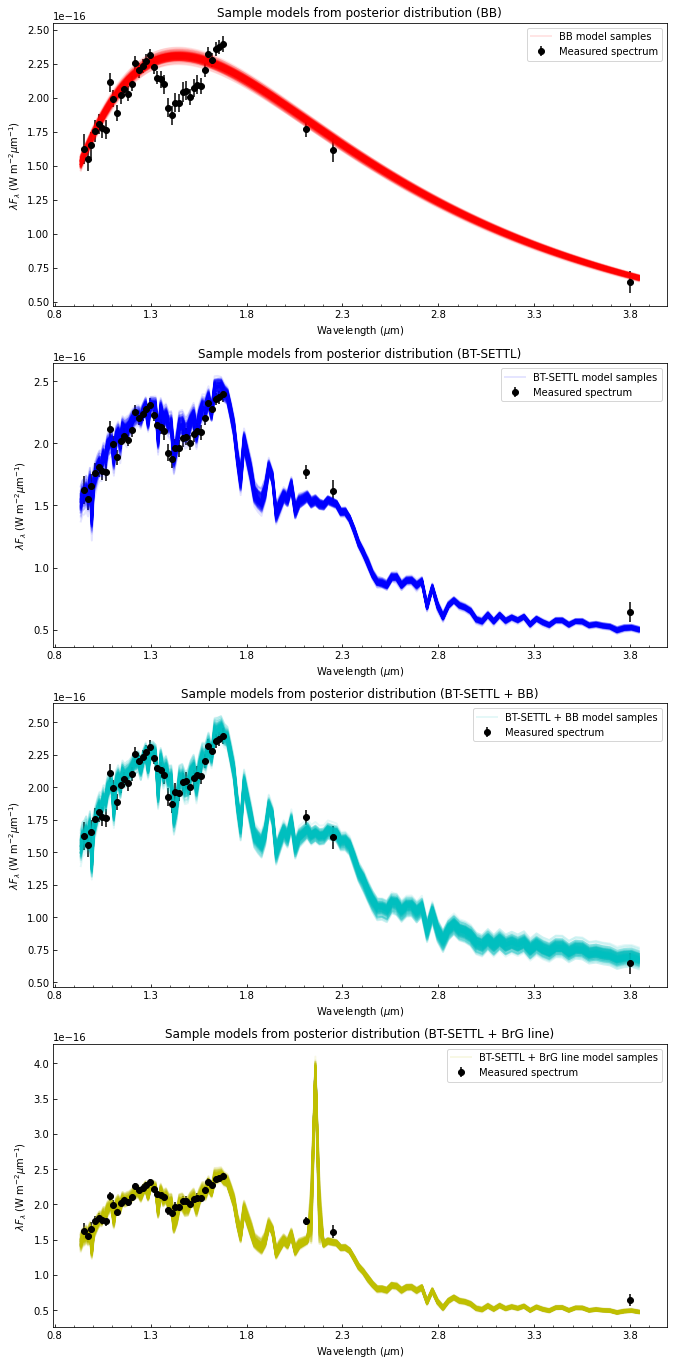

In [117]:
fig, axes = plt.subplots(4,1,figsize=(11,24))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Titles
for nn in range(n_models):
    axes[nn].set_title("Sample models from posterior distribution ({})".format(lab_models[nn]))

    # Set axes labels
    axes[nn].set_xlabel(r"Wavelength ($\mu$m)")
    axes[nn].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")

    # Options depending on model
    if nn==0 or nn ==1:
        show_labs = range(len(bf_params[nn]))
    elif nn==2:
        show_labs = range(len(bf_params[nn])-1)
    else:
        show_labs = list(range(len(bf_params[nn])-2))
    
    # Plot sample models
    lbda_samp, fluxes_model = all_plot_samples[nn]
    for i in range(n_samp):
        flux_model = fluxes_model[i]
        if i == 0:
            lab_str = '{0} = {1:.{2}f} {3}'
            lab_str_list = [lab_str.format(all_labels[nn][j], bf_params[nn][j], all_ndig[nn][j], all_units[nn][j]) for j in show_labs]
            sep = ', '
            label = "{} model samples".format(lab_models[nn])#: {}".format(lab_models[nn], sep.join(lab_str_list))
        else:
            label = None
        axes[nn].plot(lbda_samp, lbda_samp*flux_model, cols[1+nn], linewidth=2, alpha=0.1, label=label)

    min_tick = lbda[0]-dlbda[0]/2-((lbda[0]-dlbda[0]/2)%0.2)
    max_tick = lbda[-1]+dlbda[-1]/2+(0.2-((lbda[-1]+dlbda[-1]/2)%0.2))
    major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
    minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

    axes[nn].set_xticks(major_ticks1)
    axes[nn].set_xticks(minor_ticks1, minor = True)
    axes[nn].tick_params(which = 'both', direction = 'in')
            

    # Plot measured spectrum
    axes[nn].errorbar(lbda, lbda*spec, 
                     lbda*spec_err, fmt=cols[0]+'o', 
                     label='Measured spectrum')
    axes[nn].legend(loc='best')
        
plt.show()

[Go to the top](#Table-of-contents)

# 6. Nested sampler examples

The procedure to set the nested sampler routines is similar to what we saw with the MCMC, as most parameters of `mcmc_spec_sampling` and `nested_spec_sampling` are identical.

The main differences are the `sampler`, `method`, `npoints` or `dlogz` parameters for the nested samplers: 

- the `sampler` can be set to `'ultranest'` or `'nestle'`. 
- in the case of `'nestle'`, the `method` can be set to `'classic'` (MCMC; Skilling 2004), `'single'` (single ellipsoid; Mutherjee et al. 2006) or `'multi'` (original multinest implementation as in Feroz et al. 2009, with conservative ellipsoid splitting).
- `npoints` corresponds to the number of active live points (minimum number in the case of UltraNest);
- `dlogz` is the target evidence uncertainty. The stopping criterion is log(z + z_est) - log(z) < dlogz. There are additional criteria for UltraNest.

Other sampler-specific parameters (e.g. `decline_factor` and `rstate` for nestle, or `frac_remain` and `dKL` for UltraNest) can be provided as `kwargs`. The interested reader is referred to the documentation of [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html) and [nestle](http://kylebarbary.com/nestle/) for details on how to appropriately set the values of the different parameters. 

Below we show three examples of nested sampler runs, using `nestle` and `ultranest`, with the BT-SETTL grid, considering A_V as a free parameter. Let's first set the parameters as in [Sec. 4.3](#4.3.-BT-SETTL-model):

In [118]:
from utils import bts_reader

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

ini_guess = (3100., 3.5, 1.3, 1.6)

labels = ('Teff', 'logg', 'R', 'Av')
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$')
units = ('K', '', r'$R_J$', 'mag')
ndig = (0,1,2,1) # number of significant digits
units_mod = 'si'
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5)}
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'bounds':bounds,
              'units_mod':units_mod}

grid_name='bts_resamp_grid.fits' 
output_dir = path+'/static/bts_output/'
resamp_before=True
output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir}

## 6.1. Nestle - single ellipsoid method

Now let's set the parameters that are specific to the nested sampler:

In [119]:
sampler='nestle'
method='single' 
npoints=1500
dlogz=0.1

In [120]:
nested_params = {'sampler':sampler,
                 'method':method,
                 'npoints':npoints,
                 'dlogz':dlogz}

Now let's run the nested sampler. **Warning: the next cell may take up to a few minutes to complete** - reduce the number of active points for a faster calculation.

In [121]:
from special.nested_sampling import nested_spec_sampling

res = nested_spec_sampling(ini_guess, lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params,
                           **nested_params, **model_params, **output_params)


Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-10 00:00:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Teff [2000,4000]
logg [2.5,5.5]
R [0.1,5]
Av [0.0,5]

Using 1500 active points

Total running time:
Running time:  0:09:08.024054
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's plot the results:

niter: 26109
ncall: 94880
nsamples: 27609
logz: -94.400 +/-  0.093
h: 12.989

Natural log of prior volume and Weight corresponding to each sample


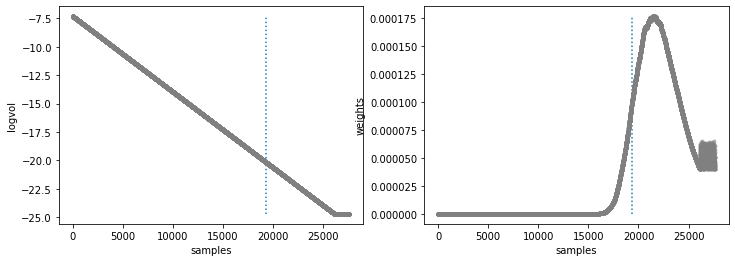


Walk plots before the burnin


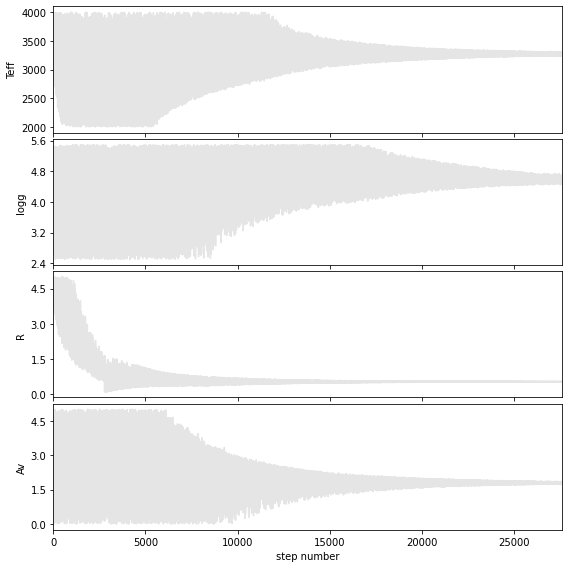


Walk plots after the burnin


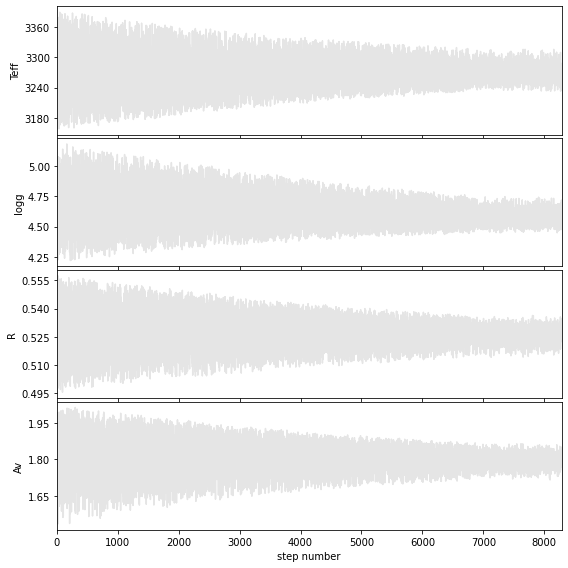


Weighted mean +- sqrt(covariance)
Teff = 3270 +/- 42
logg = 4.6 +/- 0.2
R = 0.53 +/- 0.01
Av = 1.8 +/- 0.1

Hist bins = 91


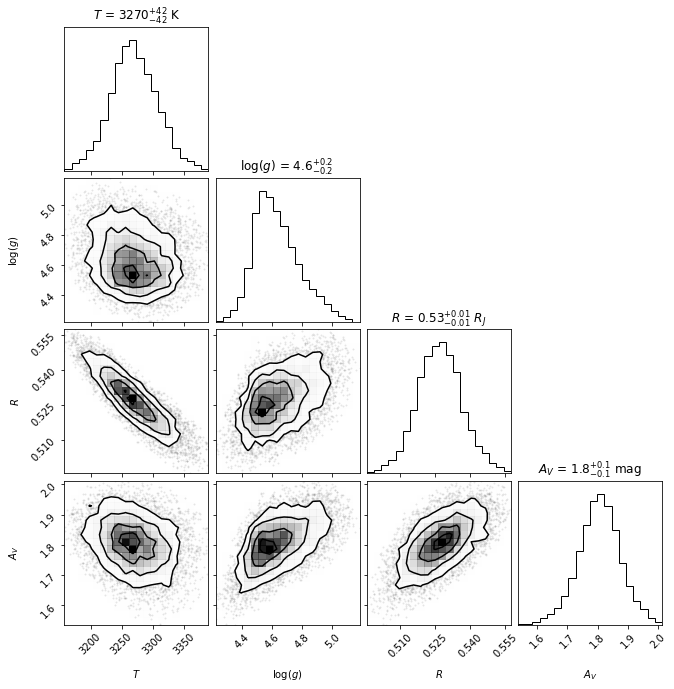


Confidence intervals
percentage for Teff: 68.31646004334337%
percentage for logg: 68.99669766964955%
percentage for R: 69.1098480528785%
percentage for Av: 69.87780962574014%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3258.6160683017683 [-39.49266904681417,52.23223970707613]
Gaussian fit results:
Teff: 3270.1787935262155 +-37.747915809527846
******* Results for logg ***** 


Confidence intervals:
logg: 4.5320107271230405 [-0.10024692312468009,0.25853153858470357]
Gaussian fit results:
logg: 4.6314814519637055 +-0.1537028029561615
******* Results for R ***** 


Confidence intervals:
R: 0.5231026499863208 [-0.007813444744495968,0.015287174500100753]
Gaussian fit results:
R: 0.5269008295164294 +-0.009657921688999187
******* Results for Av ***** 


Confidence intervals:
Av: 1.8321212706797632 [-0.10204322177451286,0.06541232165032884]
Gaussian fit results:
Av: 1.8048004894533578 +-0.06978474633540446


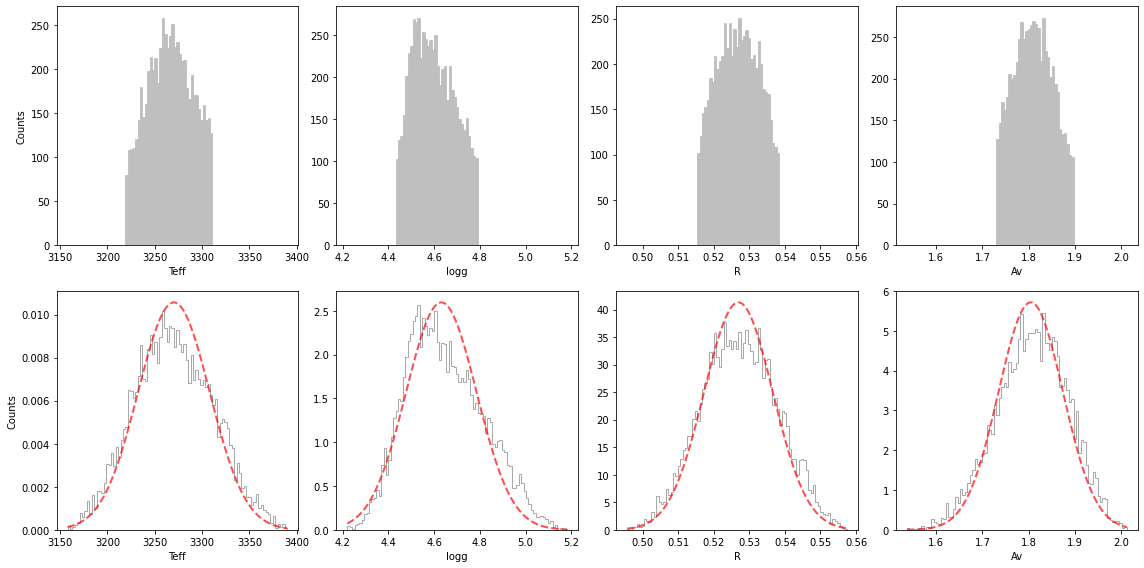

In [122]:
from special.nested_sampling import show_nestle_results

final_res = show_nestle_results(res, labels, method=method, burnin=0.7, bins=None, cfd=68.27, 
                                units=units, ndig=ndig, labels_plot=labels_plot, save=False, 
                                output_dir='./', plot=True)

The best-fit parameters, with uncertainty are:

In [123]:
for p in range(len(labels)):
    fmt = "{{:.{0}f}}".format(ndig[p]).format
    line = r"{0}: {1}+/-{2} {3}"
    print(line.format(labels[p],fmt(final_res[p][0]),fmt(final_res[p][1]), units[p]))

Teff: 3270+/-42 K
logg: 4.6+/-0.2 
R: 0.53+/-0.01 $R_J$
Av: 1.8+/-0.1 mag


## 6.2. Nestle - multi-ellipsoid method

Let's adapt the method and number of active points:

In [124]:
sampler='nestle'
method='multi' 
npoints=2000
dlogz=0.5

In [125]:
nested_params = {'sampler':sampler,
                 'method':method,
                 'npoints':npoints,
                 'dlogz':dlogz}

Now let's run the nested sampler. **Warning: the next cell may take up to a few minutes to complete** - reduce the number of active points for a faster calculation.

In [126]:
from special.nested_sampling import nested_spec_sampling

res = nested_spec_sampling(ini_guess, lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params,
                           **nested_params, **model_params, **output_params)


Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-10 00:09:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Teff [2000,4000]
logg [2.5,5.5]
R [0.1,5]
Av [0.0,5]

Using 2000 active points

Total running time:
Running time:  0:10:46.685544
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's plot the results:

niter: 31153
ncall: 109925
nsamples: 33153
logz: -94.184 +/-  0.080
h: 12.832

Natural log of prior volume and Weight corresponding to each sample


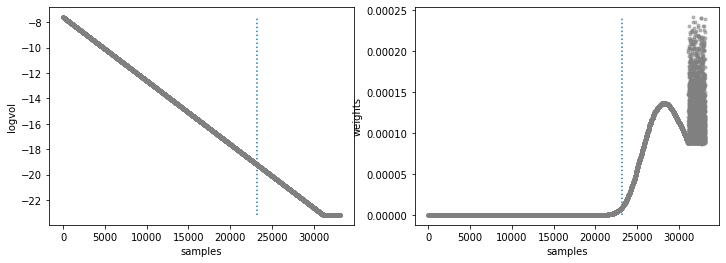


Walk plots before the burnin


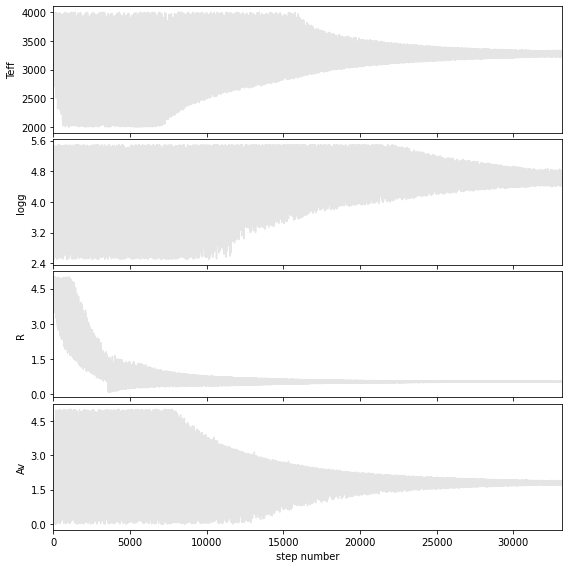


Walk plots after the burnin


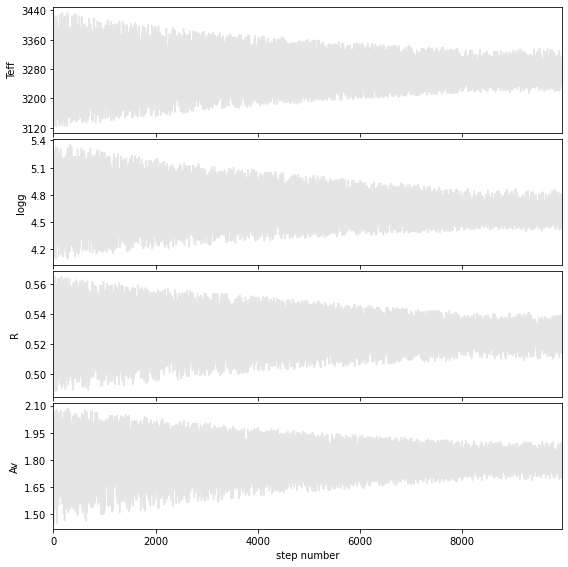


Weighted mean +- sqrt(covariance)
Teff = 3271 +/- 44
logg = 4.6 +/- 0.2
R = 0.53 +/- 0.01
Av = 1.8 +/- 0.1

Hist bins = 99


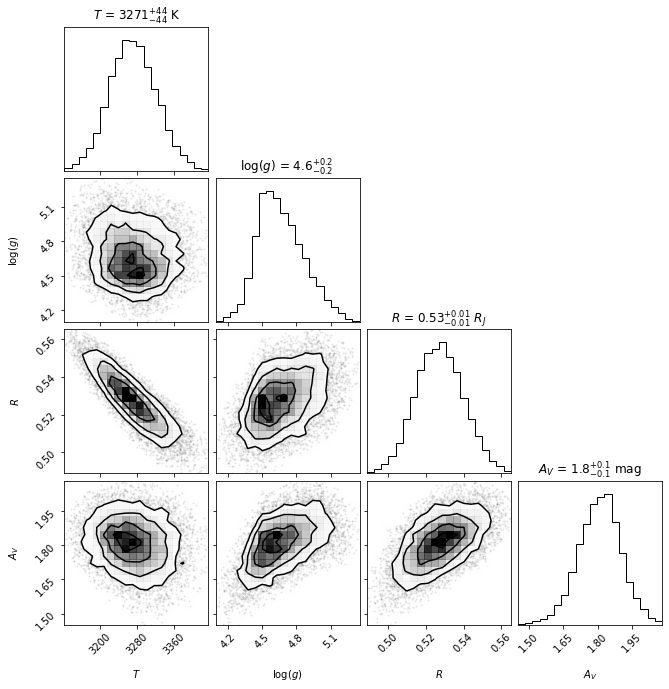


Confidence intervals
percentage for Teff: 68.61442746200976%
percentage for logg: 69.40414371913084%
percentage for R: 68.87859748525126%
percentage for Av: 68.83750747088774%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3262.1880232454296 [-42.48158360533989,48.77515154687262]
Gaussian fit results:
Teff: 3270.5158869610686 +-50.78768232871047
******* Results for logg ***** 


Confidence intervals:
logg: 4.556674161663049 [-0.1339791686728251,0.23605853528069165]
Gaussian fit results:
logg: 4.665856874164447 +-0.20438384216968633
******* Results for R ***** 


Confidence intervals:
R: 0.5307912399381789 [-0.01727546471993724,0.008829681967968073]
Gaussian fit results:
R: 0.5273442763318729 +-0.012623660960914308
******* Results for Av ***** 


Confidence intervals:
Av: 1.8432820928953786 [-0.11140678077727939,0.05411186494896425]
Gaussian fit results:
Av: 1.8084930469893075 +-0.09345267969663529


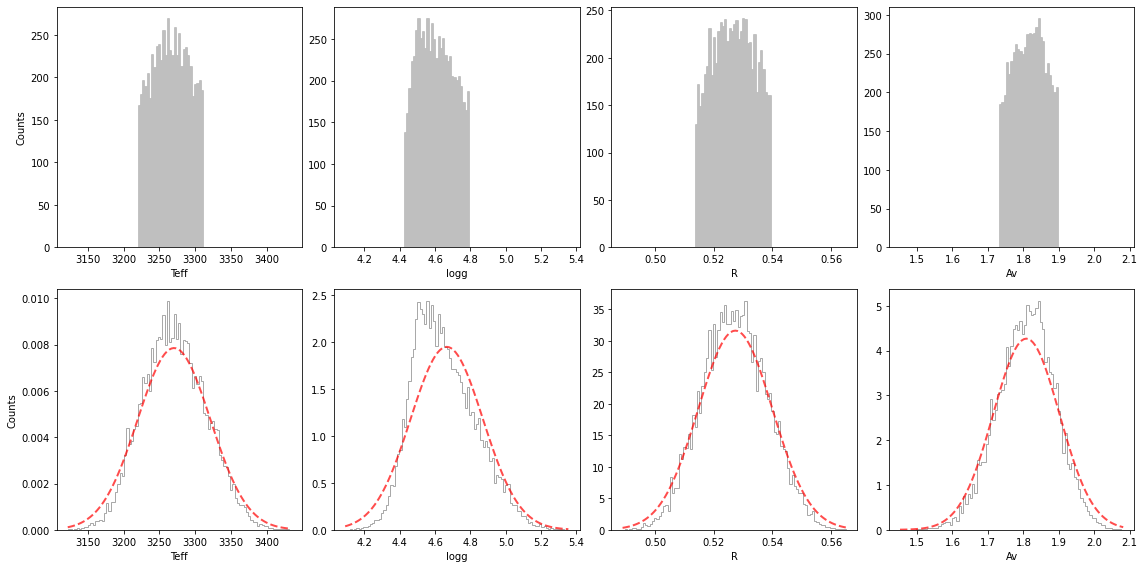

In [127]:
from special.nested_sampling import show_nestle_results

final_res = show_nestle_results(res, labels, method=method, burnin=0.7, bins=None, cfd=68.27,
                                units=units, ndig=ndig, labels_plot=labels_plot, save=False, 
                                output_dir='./', plot=True)

We see that for the case of the spectrum of CrA-9B/b with a BT-SETTL + extinction model, even when we allow for multiple nests, the highest likelihood area in the parameter space still corresponds to an individual ellipsoid.

## 6.3. UltraNest

Let's adapt the sampler and number of active points:

In [128]:
sampler='ultranest'
npoints=1000
dlogz=0.2

In [129]:
nested_params = {'sampler':sampler,
                 'method':method,
                 'npoints':npoints,
                 'dlogz':dlogz}

Now let's run the nested sampler. **Warning: the next cell may take up to a few minutes to complete** - reduce the number of active points for a faster calculation.

In [130]:
from special.nested_sampling import nested_spec_sampling

res = nested_spec_sampling(ini_guess, lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params,
                           **nested_params, **model_params, **output_params)


Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-10 00:20:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Teff [2000,4000]
logg [2.5,5.5]
R [0.1,5]
Av [0.0,5]

Using 1000 active points
[ultranest] Resuming from 20543 stored points


[ultranest] Explored until L=-8e+01   [-79.4751..-79.4751]*| it/evals=19500/49465 eff=inf% N=1000    00   0 00 0  
[ultranest] Likelihood function evaluations: 49465
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -94.37 +- 0.07785
[ultranest] Effective samples strategy satisfied (ESS = 5363.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.2)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.01 total:0.08 required:<0.20
[ultranest] done iterating.

Total running time:
Running time:  0:00:22.396396
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's plot the results:


logZ = -94.355 +- 0.140
  single instance: logZ = -94.355 +- 0.114
  bootstrapped   : logZ = -94.367 +- 0.139
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    Teff                : 3098  │ ▁▁▁▁▁▁▁▁▂▂▄▅▅▇▇▇▇▇▇▅▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁ │3476      3270 +- 44
    logg                : 4.05  │ ▁▁▁▁▁▁▁▂▃▄▅▇▇▇▇▆▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁ │5.48      4.66 +- 0.18
    R                   : 0.479 │ ▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▆▆▆▇▇▇▇▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁ │0.569     0.527 +- 0.011
    Av                  : 1.331 │ ▁    ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▇▅▄▃▂▂▁▁▁▁▁▁▁ │2.140     1.809 +- 0.083


Confidence intervals

Hist bins = 98
percentage for Teff: 69.05748319588042%
percentage for logg: 68.61098073412055%
percentage for R: 68.49686732810508%
percentage for Av: 69.70769181174423%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3258.5838073052732 [-39.84428271142815,60.81495782270622]
******* Results for logg ***** 


Confidence intervals:
logg: 4.577720445280006 [-0.145

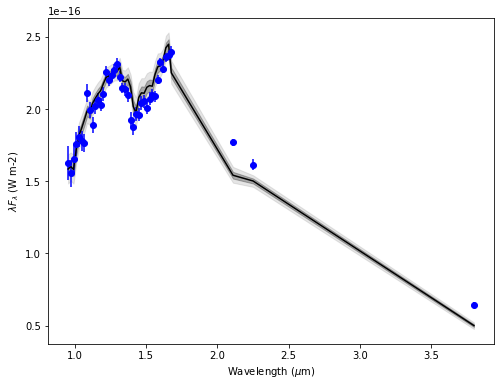

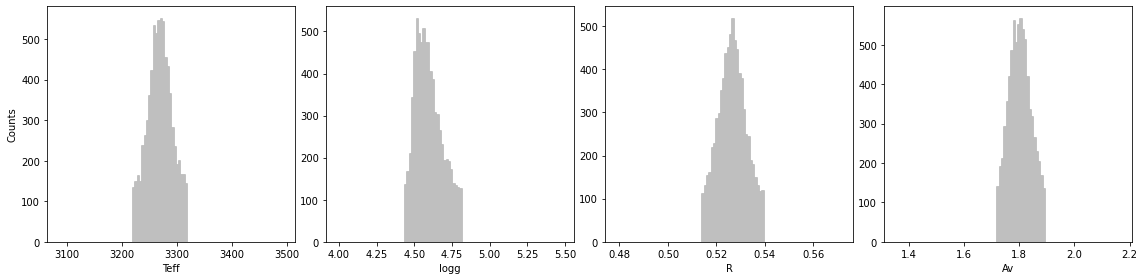

percentage for Teff: 69.05748319588042%
percentage for logg: 68.61098073412055%
percentage for R: 68.49686732810508%
percentage for Av: 69.70769181174423%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3258.5838073052732 [-39.84428271142815,60.81495782270622]
Gaussian fit results:
Teff: 3269.932232046592 +-47.65653344442819
******* Results for logg ***** 


Confidence intervals:
logg: 4.577720445280006 [-0.1451559643056921,0.2368334154461298]
Gaussian fit results:
logg: 4.644950396124002 +-0.19952209766044599
******* Results for R ***** 


Confidence intervals:
R: 0.5256796962813602 [-0.011878513577833094,0.013779075750286363]
Gaussian fit results:
R: 0.5270857975433556 +-0.011702451604743036
******* Results for Av ***** 


Confidence intervals:
Av: 1.829998138709031 [-0.11273860280808967,0.06263255711560567]
Gaussian fit results:
Av: 1.8050380170168783 +-0.08960446777712383


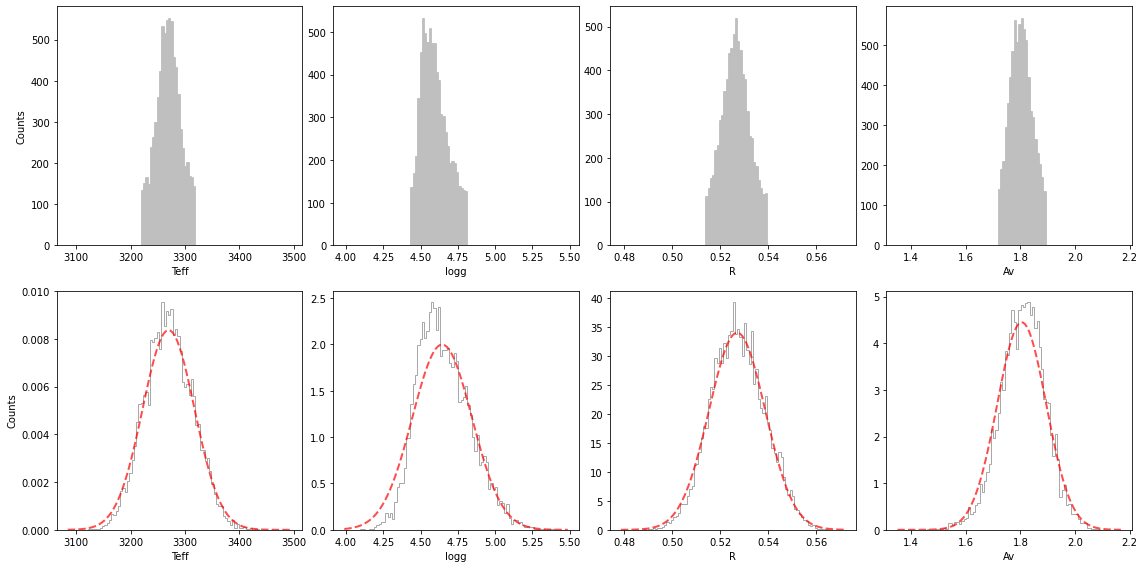

Teff = 3270 +/- 7
logg = 4.6 +/- 0.4
R = 0.53 +/- 0.11
Av = 1.8 +/- 0.3


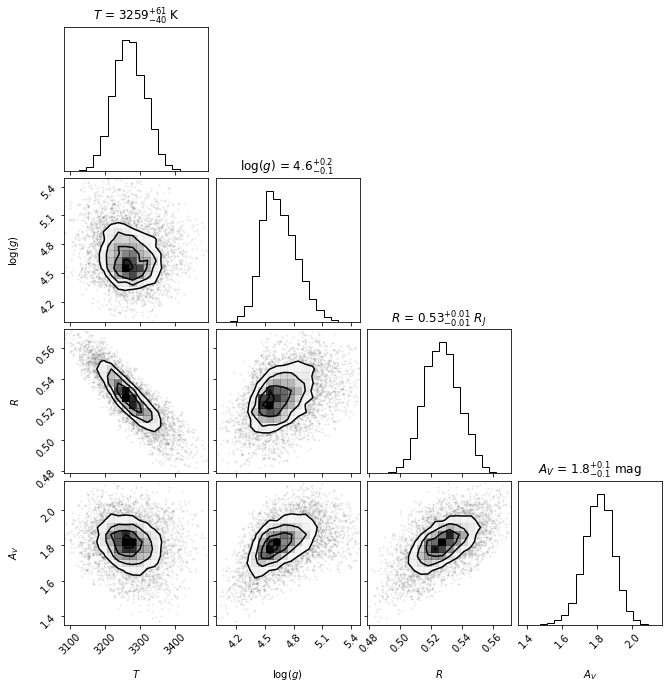

In [131]:
from special.nested_sampling import show_ultranest_results

del model_params["bounds"] # unused for ultranest results plot
del instru_params["instru_corr"] # unused for ultranest results plot
final_res = show_ultranest_results(res, bins=None, cfd=68.27, save=False, plot=True, 
                                   units=units, ndig=ndig, labels_plot=labels_plot, 
                                   lbda_obs=lbda, spec_obs=spec, spec_obs_err=spec_err, dist=d_st, 
                                   **model_params, **instru_params)

We see that for the case of the spectrum of CrA-9B/b with a BT-SETTL + extinction model, UltraNest also finds that the highest likelihood area in the parameter space corresponds to an individual ellipsoid.

# 7. Best-fit template spectrum

In this section, we will find the best-fit template spectra to our measured spectrum in the Montreal Spectral Library of observed M-L-T type low-mass objects. Since the template spectra from this library typically do not cover wavelengths longward of the K band, we will discard the NACO L' point from the spectrum, just for the sake of this exercise: 

In [132]:
lbda_crop = lbda[:-1]
spec_crop = spec[:-1]
spec_err_crop = spec_err[:-1]
dlbda_crop = dlbda[:-1]

Let's define the parameters associated to the instrument(s) which acquired the spectrum (again we discard the NACO measurement):

In [133]:
instru_res_crop = instru_res[:-1]
instru_idx_crop = instru_idx[:-1]
final_sp_corr_crop = final_sp_corr[:-1,:-1]

instru_params = {'instru_res':instru_res_crop,
                 'instru_idx':instru_idx_crop,
                 'instru_corr':final_sp_corr_crop,
                 'filter_reader':filter_reader}

For this exercice, we have downloaded the MSL library following the instructions on the page of J. Gagné: https://jgagneastro.com/the-montreal-spectral-library/

Below, we then set the folder in which the template spectra placed, and their extension ('.fits', for automatic identification of spectra in that folder). We also define the snippet function `tmp_reader` to read the template spectra in the utils.py file, loaded below.

In [134]:
from utils import tmp_reader
inpath_models = path+'/static/MSL/'
tmp_endswith='.fits'
tmp_params = {'tmp_reader':tmp_reader,
              'lib_dir':inpath_models,
              'tmp_endswith':tmp_endswith}

Let's assume we are interested in the top 3 most similar template spectra:

In [135]:
n_best=3

Let's use the Nelder-Mead algorithm to find the optimal flux scaling factor and $A_V$ to be applied to each template. Additional options for the simplex can be set with `simplex_options` (example above) - these will be provided to the `scipy.minimize` function. 

In [136]:
search_mode = 'simplex' #'grid'
simplex_options = {'xatol': 1e-6, 'fatol': 1e-6, 'maxiter': 1000, 'maxfev': 5000}
AV_range = (-3, 7, 0.1) # min, max, step. Note: in simplex mode, min and max values are only used to set a chi=np.inf outside of these bounds.

search_opt = {'search_mode':search_mode,
              'simplex_options':simplex_options, 
              #'scale_range':(0.2, 5, 0.05),# min, max, step
              'ext_range':AV_range}

Alternatively, one can set `search_mode` to `'grid'`, which will simply use a grid search to find the optimal $A_V$ and flux scaling factors to be applied to the template spectra for comparison to the measured spectrum. This is slower but avoids the risk of a failed minimization. In this case, both the `AV_range` and `scale_range` parameters have to be set.

Some template spectra may be corrupted or unusable for this specific spectrum (e.g. wrong wavelength coverage), let's force the algorithm to continue instead of raising an error.

In [137]:
force_continue=True

Some template spectra will have a sufficient wavelength coverage (Y to K), but with missing points (NaN values) in between bands (e.g. between J and H bands, or H and K bands). For a given template spectrum to be considered valid, it is recommeded to set a minimum threshold in terms of number of non-NaN resampled points. The risk of not doing that is to end up with best-fit template spectra with very few - but very well fitting - points minimizing our $\chi_r^2$ metric.

Let's set this threshold to cover >80% of our observed spectrum, i.e. 34 points:

In [138]:
min_npts = 34

Now let's find the best-fit templates:

In [139]:
from special.template_fit import best_fit_tmp

final_res = best_fit_tmp(lbda_crop, spec_crop, spec_err_crop, dlbda_obs=dlbda_crop, n_best=n_best, 
                         **tmp_params, **search_opt, **instru_params, force_continue=force_continue, 
                         verbosity=1, nproc=1, min_npts=min_npts)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-10 00:29:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
424 template spectra will be tested.
****************************************

Unsufficient number of good points (33 < 34). Tmp discarded.
1/424 (2MASSJ0428+1839_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0313-2447_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
2/424 (2MASSJ0313-2447_NIR_Flamingos-2_Gagne2015c.fits) FAILED
3/424: SIMPJ2215+2110_NIR_SpeX_Robert2016, chi_r^2 = 43.1, ndof=39
Unsufficient number of good points (33 < 34). Tmp discarded.
4/424 (2MASSJ2353-1844A_NIR_SpeX_Gagne2015c.fits) FAILED
Wavelength range of template SIMPJ1150+0520_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
5/424 (SIMPJ1150+0

I_R_A_FNAME= 'J2353A_merge'       /                                              [astropy.io.fits.card]


7/424: 2MASSJ1045-2819_NIR_SpeX_Gagne2015c, chi_r^2 = 5.4, ndof=33
8/424: SIMPJ1501-1831_NIR_SpeX_Robert2016, chi_r^2 = 10.5, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2251-6811_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
9/424 (2MASSJ2251-6811_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2251-6811_ALLCOMB_merge' /                                        [astropy.io.fits.card]


10/424: SIMPJ0429+0607_NIR_GNIRS_Robert2016, chi_r^2 = 34.6, ndof=39
11/424: SIMPJ1058+1339_NIR_SIMON_Robert2016, chi_r^2 = 22.4, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0752-7947_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
12/424 (2MASSJ0752-7947_NIR_Flamingos-2_Gagne2015c.fits) FAILED
13/424: 2MASSJ0443+0002_NIR_SpeX_Gagne2015c, chi_r^2 = 14.7, ndof=39
Wavelength range of template SIMPJ2148+2239_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
14/424 (SIMPJ2148+2239_NIR_NIRI_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2202-5605_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
15/424 (2MASSJ2202-5605_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2202-5605_ALLCOMB_merge' /                                        [astropy.io.fits.card]


16/424: SIMPJ0951-1343_NIR_SIMON_Robert2016, chi_r^2 = 33.6, ndof=39
17/424: 2MASSJ1119-3917_NIR_SpeX_Gagne2015c, chi_r^2 = 2.6, ndof=33
18/424: SIMPJ1627+0836_NIR_SpeX_Robert2016, chi_r^2 = 11.3, ndof=39
19/424: 2MASSJ0344+0716B_NIR_SpeX_Gagne2015c, chi_r^2 = 3.3, ndof=33
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ1510-1147_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
20/424 (SIMPJ1510-1147_NIR_SpeX_Robert2016.fits) FAILED
21/424: SIMPJ1415+2635_NIR_SpeX_Robert2016, chi_r^2 = 14.5, ndof=39
Wavelength range of template SIMPJ1613-0747_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
22/424 (SIMPJ1613-0747_NIR_NIRI_Robert2016.fits) FAILED
Unsufficient number of good points (30 < 34). Tmp discarded.
23/424 (2MASSJ2240+0532_NIR_SpeX_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2240+0532_merge'   /                                              [astropy.io.fits.card]


24/424: SIMPJ2322-1407_NIR_SpeX_Robert2016, chi_r^2 = 26.6, ndof=39
Wavelength range of template SIMPJ1225-1013_NIR_GNIRS_Robert2016.fits (1.00, 2.52)mu too short compared to that of observed spectrum (0.95, 2.25)mu
25/424 (SIMPJ1225-1013_NIR_GNIRS_Robert2016.fits) FAILED
No indices match the constraint (ceil w.r.t 2.36)
Issue with resampling of template SIMPJ2318-1301_NIR_SIMON_Robert2016.fits. Does the wavelength range extend far enough (0.80, 2.27)mu?
26/424 (SIMPJ2318-1301_NIR_SIMON_Robert2016.fits) FAILED
27/424: SIMPJ1217+0708_NIR_GNIRS_Robert2016, chi_r^2 = 14.4, ndof=35
28/424: SIMPJ0858+2710_NIR_GNIRS_Robert2016, chi_r^2 = 115.6, ndof=35
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0120-5200_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
29/424 (2MASSJ0120-5200_NIR_Flamingos-2_Gagne2015c.fits) FAILED
30/424: SIMPJ0150+3827_NIR_SpeX_Robert2016, chi_r^2 = 30.7, ndof=39
Unsufficient number

I_R_A_FNAME= 'J2041-3506_ALLCOMB_merge' /                                        [astropy.io.fits.card]
I_R_A_FNAME= 'J22191486-6828018_ALLCOMB_merge' /                                 [astropy.io.fits.card]


37/424: SIMPJ1211+0406_NIR_SIMON_Robert2016, chi_r^2 = 18.2, ndof=39
38/424: SIMPJ0148+3712_NIR_SpeX_Robert2016, chi_r^2 = 17.2, ndof=39
39/424: SIMPJ1308+0818_NIR_SpeX_Robert2016, chi_r^2 = 9.1, ndof=39
40/424: SIMPJ0851+1043_NIR_GNIRS_Robert2016, chi_r^2 = 201.1, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0226-5327_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
41/424 (2MASSJ0226-5327_NIR_Flamingos-2_Gagne2015c.fits) FAILED
42/424: 2MASSJ0335+2342_NIR_SpeX_Gagne2015c, chi_r^2 = 7.8, ndof=39
43/424: SIMPJ2150-0412_NIR_SIMON_Robert2016, chi_r^2 = 24.8, ndof=39
Wavelength range of template SIMPJ1755+3618_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
44/424 (SIMPJ1755+3618_NIR_NIRI_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0541-0217_NIR_Flamingos-2_Gagne2015c.

I_R_A_FNAME= 'J2244-3045_merge'   /                                              [astropy.io.fits.card]


49/424: 2MASSJ2244-3045_NIR_SpeX_Gagne2015c, chi_r^2 = 13.0, ndof=35
Wavelength range of template SIMPJ1414+0107_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
50/424 (SIMPJ1414+0107_NIR_NIRI_Robert2016.fits) FAILED
51/424: 2MASSJ0758+15301A_NIR_SpeX_Gagne2015c, chi_r^2 = 3.1, ndof=32
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0038-6403_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
52/424 (2MASSJ0038-6403_NIR_Flamingos-2_Gagne2015c.fits) FAILED
53/424: SIMPJ1058+1339_NIR_GNIRS_Robert2016, chi_r^2 = 36.0, ndof=39
54/424: SIMPJ0429+0607_NIR_SIMON_Robert2016, chi_r^2 = 24.5, ndof=39
55/424: 2MASSJ1411-2119_NIR_SpeX_Gagne2015c, chi_r^2 = 9.5, ndof=39
56/424: 2MASSJ0856-1342_NIR_SpeX_Gagne2015c, chi_r^2 = 10.1, ndof=39
57/424: 2MASSJ1207-3900_NIR_SpeX_Gagne2015c, chi_r^2 = 19.4, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue

I_R_A_FNAME= 'J2335-3401_ALLCOMB_merge' /                                        [astropy.io.fits.card]


68/424: 2MASSJ0404+2616B_NIR_SpeX_Gagne2015c, chi_r^2 = 8.1, ndof=32
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1547-1626B_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
69/424 (2MASSJ1547-1626B_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1227-0636_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
70/424 (2MASSJ1227-0636_NIR_Flamingos-2_Gagne2015c.fits) FAILED
71/424: 2MASSJ1948+5944B_NIR_SpeX_Gagne2015c, chi_r^2 = 3.5, ndof=35
Unsufficient number of good points (33 < 34). Tmp discarded.
72/424 (2MASSJ2011-5048_NIR_FIRE_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0259-4232_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
73/424 (2MASSJ0259-4232_NIR_Flamingos-2_Gagne2

I_R_A_FNAME= 'W2011-5048_tc.fits' /                                              [astropy.io.fits.card]


74/424: 2MASSJ1153-3015_NIR_SpeX_Gagne2015c, chi_r^2 = 2.7, ndof=33
75/424: SIMPJ2303+3150_NIR_SpeX_Robert2016, chi_r^2 = 70.2, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1156-4043_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
76/424 (2MASSJ1156-4043_NIR_Flamingos-2_Gagne2015c.fits) FAILED
77/424: SIMPJ1211+0406_NIR_GNIRS_Robert2016, chi_r^2 = 107.9, ndof=36
78/424: 2MASSJ1035-2058_NIR_SpeX_Gagne2015c, chi_r^2 = 3.3, ndof=33
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0314+1603_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
79/424 (2MASSJ0314+1603_NIR_SpeX_Gagne2015c.fits) FAILED
80/424: SIMPJ1317+0448_NIR_SpeX_Robert2016, chi_r^2 = 14.4, ndof=39
81/424: 2MASSJ0001+1535_NIR_FIRE_Gagne2015c, chi_r^2 = 20.9, ndof=39
82/424: SIMPJ1343-1216_NIR_SIMON_Robert2016, chi_r^2 = 27.4, ndof=39
2MASSJ0039+1330B_N

I_R_A_FNAME= 'J2244-6650_ALLCOMB_merge' /                                        [astropy.io.fits.card]


93/424: SIMPJ1039-1904_NIR_SpeX_Robert2016, chi_r^2 = 13.0, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1133-7807_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
94/424 (2MASSJ1133-7807_NIR_Flamingos-2_Gagne2015c.fits) FAILED
95/424: 2MASSJ1207-3900_NIR_SpeX_Gagne2014b, chi_r^2 = 19.4, ndof=39
96/424: SIMPJ0135+0205_NIR_SIMON_Robert2016, chi_r^2 = 23.4, ndof=39
97/424: SIMPJ0956-1447_NIR_SpeX_Robert2016, chi_r^2 = 37.4, ndof=39
Unsufficient number of good points (33 < 34). Tmp discarded.
98/424 (2MASSJ2335-1908_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0819-0450_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
99/424 (2MASSJ0819-0450_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Wavelength range of template SIMPJ1158+0435_NIR_SpeX_Robert2016.fits (1.13, 2.43)mu too shor

I_R_A_FNAME= 'J2335-1908_merge'   /                                              [astropy.io.fits.card]
I_R_A_FNAME= 'W2343-3646_tc.fits' /                                              [astropy.io.fits.card]


103/424: SIMPJ0006-1319_NIR_GNIRS_Robert2016, chi_r^2 = 135.5, ndof=35
104/424: SIMPJ0532-3253_NIR_GNIRS_Robert2016, chi_r^2 = 216.5, ndof=38
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0148-5201_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
105/424 (2MASSJ0148-5201_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2028-5637_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
106/424 (2MASSJ2028-5637_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2028-5637_ALLCOMB_merge' /                                        [astropy.io.fits.card]


107/424: 2MASSJ0758+15300_NIR_SpeX_Gagne2015c, chi_r^2 = 2.9, ndof=32
108/424: SIMPJ1324+1906_NIR_GNIRS_Robert2016, chi_r^2 = 88.3, ndof=39
Wavelength range of template 2MASSJ2235-5906_NIR_Flamingos-2_Gagne2015c.fits (0.89, 1.89)mu too short compared to that of observed spectrum (0.95, 2.25)mu
109/424 (2MASSJ2235-5906_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0129-0823_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
110/424 (2MASSJ0129-0823_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0819-7401_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
111/424 (2MASSJ0819-7401_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0537-0623_NIR_Flamingos-2_Gagne

I_R_A_FNAME= 'J2235-5906_BEAMS_AB_140710_386_387_388_389_comb.fits' /            [astropy.io.fits.card]


113/424: SIMPJ1307-0558_NIR_GNIRS_Robert2016, chi_r^2 = 262.0, ndof=36
114/424: 2MASSJ1207-3932_NIR_SpeX_Gagne2015c, chi_r^2 = 10.2, ndof=33
Wavelength range of template SIMPJ1118-0856_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
115/424 (SIMPJ1118-0856_NIR_NIRI_Robert2016.fits) FAILED
116/424: SIMPJ1629+0335_NIR_SIMON_Robert2016, chi_r^2 = 49.5, ndof=39
117/424: SIMPJ0357+1529_NIR_GNIRS_Robert2016, chi_r^2 = 20.1, ndof=39
118/424: SIMPJ0400-1322_NIR_GNIRS_Robert2016, chi_r^2 = 124.5, ndof=38
Wavelength range of template 2MASSJ1207-3900_OPT_MAGE_Gagne2014b.fits (38240.71, 43051.20)mu too short compared to that of observed spectrum (0.95, 2.25)mu
119/424 (2MASSJ1207-3900_OPT_MAGE_Gagne2014b.fits) FAILED
120/424: SIMPJ1627+0546_NIR_SpeX_Robert2016, chi_r^2 = 8.2, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2000-7523_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range ex

I_R_A_FNAME= 'J20004841-7523070_ALLCOMB_merge' /                                 [astropy.io.fits.card]
I_R_A_FNAME= 'spc0070.a.fits'                                                    [astropy.io.fits.card]


122/424: 2MASSJ2154-1055_NIR_SpeX_Gagne2015c, chi_r^2 = 22.7, ndof=39
123/424: 2MASSJ0536-1920_NIR_SpeX_Gagne2015c, chi_r^2 = 39.8, ndof=32
124/424: SIMPJ0422+1033_NIR_SIMON_Robert2016, chi_r^2 = 9.9, ndof=39
Wavelength range of template SIMPJ1333-0215_NIR_SpeX_Robert2016.fits (1.13, 2.43)mu too short compared to that of observed spectrum (0.95, 2.25)mu
125/424 (SIMPJ1333-0215_NIR_SpeX_Robert2016.fits) FAILED
126/424: SIMPJ1452+1114_NIR_SpeX_Robert2016, chi_r^2 = 15.4, ndof=39
Unsufficient number of good points (31 < 34). Tmp discarded.
127/424 (2MASSJ2310-0748_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0649-3823_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
128/424 (2MASSJ0649-3823_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2310-0748_merge'   /                                              [astropy.io.fits.card]


129/424: SIMPJ1613-0747_NIR_GNIRS_Robert2016, chi_r^2 = 47.5, ndof=38
130/424: SIMPJ0552+0210_NIR_GNIRS_Robert2016, chi_r^2 = 203.1, ndof=36
131/424: SIMPJ0417-1345_NIR_SpeX_Robert2016, chi_r^2 = 10.5, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0018-6703_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
132/424 (2MASSJ0018-6703_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0300-5459_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
133/424 (2MASSJ0300-5459_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'W2315-4747_tc.fits' /                                              [astropy.io.fits.card]


134/424: 2MASSJ2315-4747_NIR_FIRE_Gagne2015c, chi_r^2 = 13.6, ndof=33
135/424: SIMPJ0316+2650_NIR_SpeX_Robert2016, chi_r^2 = 65.4, ndof=39
Unsufficient number of good points (30 < 34). Tmp discarded.
136/424 (2MASSJ1621-2346_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0320-3313_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
137/424 (2MASSJ0320-3313_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1101-7735_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
138/424 (2MASSJ1101-7735_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Unsufficient number of good points (33 < 34). Tmp discarded.
139/424 (2MASSJ2048-5127_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Wavelength range of template SIMPJ1004-1127_NIR_GNIRS_Robert2016.fits (1.00, 2.52)mu too short com

I_R_A_FNAME= 'W2048-5127_tc.fits' /                                              [astropy.io.fits.card]


141/424: 2MASSJ0339-2434_NIR_SpeX_Gagne2015c, chi_r^2 = 3.8, ndof=38
Unsufficient number of good points (33 < 34). Tmp discarded.
142/424 (2MASSJ1529+6312_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0355-1032_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
143/424 (2MASSJ0355-1032_NIR_Flamingos-2_Gagne2015c.fits) FAILED
144/424: SIMPJ0414+1529_NIR_SpeX_Robert2016, chi_r^2 = 7.7, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1257-4111_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
145/424 (2MASSJ1257-4111_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2048-3255_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
146/424 (2MASSJ2048-3255_NIR_SpeX_Gagne

I_R_A_FNAME= 'J2048-3255_merge'   /                                              [astropy.io.fits.card]


147/424: SIMPJ1147+2153_NIR_SpeX_Robert2016, chi_r^2 = 12.5, ndof=39
SIMPJ2332-1249_NIR_SpeX_Robert2016.fits could not be opened. Corrupt file?
148/424 (SIMPJ2332-1249_NIR_SpeX_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0635-6234_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
149/424 (2MASSJ0635-6234_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (ceil w.r.t 2.36)
Issue with resampling of template SIMPJ0008+0806_NIR_SIMON_Robert2016.fits. Does the wavelength range extend far enough (0.80, 2.35)mu?
150/424 (SIMPJ0008+0806_NIR_SIMON_Robert2016.fits) FAILED


I_R_A_FNAME= 'J2327+3858_merge'   /                                              [astropy.io.fits.card]


151/424: 2MASSJ2327+3858_NIR_SpeX_Gagne2015c, chi_r^2 = 4.8, ndof=32
152/424: 2MASSJ1358-0046_NIR_SpeX_Gagne2015c, chi_r^2 = 4.7, ndof=39
153/424: SIMPJ2327+1517_NIR_SpeX_Robert2016, chi_r^2 = 19.8, ndof=39
154/424: SIMPJ0049+0440_NIR_GNIRS_Robert2016, chi_r^2 = 30.8, ndof=39
155/424: 2MASSJ0825-0029_NIR_FIRE_Gagne2015c, chi_r^2 = 9.2, ndof=32
156/424: SIMPJ2154-1055_NIR_SpeX_Gagne2014c, chi_r^2 = 22.7, ndof=39
157/424: SIMPJ0006-1319_NIR_SIMON_Robert2016, chi_r^2 = 27.0, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0244-3548_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
158/424 (2MASSJ0244-3548_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Unsufficient number of good points (29 < 34). Tmp discarded.
159/424 (2MASSJ0342-2904_NIR_FIRE_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0311+0106_NIR_Flamingos-2_Gagne2015c.fits. Doe

I_R_A_FNAME= 'J2149-6413_ALLCOMB_merge' /                                        [astropy.io.fits.card]


175/424: 2MASSJ0820-7514_NIR_FIRE_Gagne2015c, chi_r^2 = 13.7, ndof=33
176/424: SIMPJ2309+1003_NIR_GNIRS_Robert2016, chi_r^2 = 83.9, ndof=39
177/424: 2MASSJ0805+2505B_NIR_SpeX_Gagne2015c, chi_r^2 = 4.4, ndof=39
178/424: SIMPJ1613-0747_NIR_SIMON_Robert2016, chi_r^2 = 14.0, ndof=39
179/424: 2MASSJ0951+3558_NIR_SpeX_Gagne2015c, chi_r^2 = 3.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2325-0259_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
180/424 (2MASSJ2325-0259_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0407+1546_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
181/424 (2MASSJ0407+1546_NIR_SpeX_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2325-0259'         /                                              [astropy.io.fits.card]


182/424: SIMPJ2254+1640_NIR_SpeX_Robert2016, chi_r^2 = 14.4, ndof=39
183/424: 2MASSJ1623-2353_NIR_SpeX_Gagne2015c, chi_r^2 = 14.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template GUPscb_NIR_GNIRS_Naud2014.fits. Does the wavelength range extend far enough (0.94, 2.35)mu?
184/424 (GUPscb_NIR_GNIRS_Naud2014.fits) FAILED
Wavelength range of template SIMPJ1132-3809_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
185/424 (SIMPJ1132-3809_NIR_NIRI_Robert2016.fits) FAILED
186/424: 2MASSJ0526-1824_NIR_SpeX_Gagne2015c, chi_r^2 = 5.0, ndof=34
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1204-2806_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
187/424 (2MASSJ1204-2806_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0540-0923_NIR

I_R_A_FNAME= 'J2112-8128_ALLCOMB_merge' /                                        [astropy.io.fits.card]


191/424: SIMPJ0013+0841_NIR_SIMON_Robert2016, chi_r^2 = 20.7, ndof=39
Unsufficient number of good points (33 < 34). Tmp discarded.
192/424 (2MASSJ1939-5216_NIR_FIRE_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2148-4736_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
193/424 (2MASSJ2148-4736_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'W1939-5216_tc.fits' /                                              [astropy.io.fits.card]
I_R_A_FNAME= 'J2148-4736_ALLCOMB_merge' /                                        [astropy.io.fits.card]


194/424: SIMPJ1117+1857_NIR_GNIRS_Robert2016, chi_r^2 = 286.3, ndof=36
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0355+1133_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
195/424 (2MASSJ0355+1133_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2005-6258_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
196/424 (2MASSJ2005-6258_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ0211-1427_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
197/424 (SIMPJ0211-1427_NIR_SpeX_Robert2016.fits) FAILED


I_R_A_FNAME= 'J2005-6258_ALLCOMB_merge' /                                        [astropy.io.fits.card]


198/424: SIMPJ1041-0429_NIR_GNIRS_Robert2016, chi_r^2 = 21.0, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0804-6346_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
199/424 (2MASSJ0804-6346_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Wavelength range of template SIMPJ1343-1216_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
200/424 (SIMPJ1343-1216_NIR_NIRI_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1903-3723_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
201/424 (2MASSJ1903-3723_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J1903-3723_ALLCOMB_merge' /                                        [astropy.io.fits.card]
I_R_A_FNAME= 'J1948+5944A_merge'  /                                              [astropy.io.fits.card]


202/424: 2MASSJ1948+5944A_NIR_SpeX_Gagne2015c, chi_r^2 = 3.1, ndof=32
Wavelength range of template 2MASSJ1846-5706_NIR_Flamingos-2_Gagne2015c.fits (0.90, 1.90)mu too short compared to that of observed spectrum (0.95, 2.25)mu
203/424 (2MASSJ1846-5706_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0453-1751_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
204/424 (2MASSJ0453-1751_NIR_SpeX_Gagne2015c.fits) FAILED
Unsufficient number of good points (33 < 34). Tmp discarded.
205/424 (2MASSJ2048-5127_NIR_FIRE_Gagne2015c.fits) FAILED
206/424: SIMPJ1537-0800_NIR_GNIRS_Robert2016, chi_r^2 = 169.0, ndof=36
Wavelength range of template SIMPJ2322-1407_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
207/424 (SIMPJ2322-1407_NIR_NIRI_Robert2016.fits) FAILED
208/424: SIMPJ2132-1452_NIR_SIMON_Robert2016, chi_r^2 = 102.1, ndof=39


I_R_A_F-TLM= '2013-07-18T21:19:33' / Time of last modification                   [astropy.io.fits.card]


226/424: SIMPJ0251-0818_NIR_SIMON_Robert2016, chi_r^2 = 17.0, ndof=39


I_R_A_FNAME= 'J1846+5246_A_merge' /                                              [astropy.io.fits.card]


227/424: 2MASSJ1846+5246A_NIR_SpeX_Gagne2015c, chi_r^2 = 8.0, ndof=32
2MASSJ0039+1330A_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
228/424 (2MASSJ0039+1330A_NIR_SpeX_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1257-3635_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
229/424 (2MASSJ1257-3635_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J12574463-3635431_ALLCOMB_merge' /                                 [astropy.io.fits.card]


230/424: SIMPJ1150+0520_NIR_SpeX_Robert2016, chi_r^2 = 20.2, ndof=39
231/424: 2MASSJ1013-1706B_NIR_SpeX_Gagne2015c, chi_r^2 = 3.1, ndof=39
232/424: SIMPJ1141+1941_NIR_GNIRS_Robert2016, chi_r^2 = 22.8, ndof=35
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ1003-1441_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
233/424 (SIMPJ1003-1441_NIR_SpeX_Robert2016.fits) FAILED
234/424: SIMPJ1631-1922_NIR_SpeX_Robert2016, chi_r^2 = 3.5, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2235-3844_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
235/424 (2MASSJ2235-3844_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0326-0617_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
236/424 (2MASSJ0326-0617_NIR_SpeX_

I_R_A_FNAME= 'J2235-3844_ALLCOMB_merge' /                                        [astropy.io.fits.card]


237/424: 2MASSJ0518-3101_NIR_SpeX_Gagne2015c, chi_r^2 = 7.2, ndof=37
238/424: SIMPJ1422+0827_NIR_SIMON_Robert2016, chi_r^2 = 31.3, ndof=39
2MASSJ2331-0406_NIR_Flamingos-2_Gagne2015c.fits could not be opened. Corrupt file?
239/424 (2MASSJ2331-0406_NIR_Flamingos-2_Gagne2015c.fits) FAILED


    Header size is not multiple of 2880: 11366
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


240/424: SIMPJ1339+1523_NIR_SIMON_Robert2016, chi_r^2 = 13.0, ndof=39
241/424: 2MASSJ1226-3316_NIR_SpeX_Gagne2015c, chi_r^2 = 3.4, ndof=32
242/424: SIMPJ1615+1340_NIR_SIMON_Robert2016, chi_r^2 = 135.2, ndof=39
243/424: 2MASSJ0758+15301B_NIR_SpeX_Gagne2015c, chi_r^2 = 3.6, ndof=32
244/424: 2MASSJ1247-3816_NIR_SpeX_Gagne2014b, chi_r^2 = 9.2, ndof=39
245/424: SIMPJ0026-0936_NIR_SpeX_Robert2016, chi_r^2 = 8.3, ndof=39
246/424: 2MASSJ1005+1703_NIR_SpeX_Gagne2015c, chi_r^2 = 4.2, ndof=39
2MASSJ0017-3219_NIR_Flamingos-2_Gagne2015c.fits could not be opened. Corrupt file?
247/424 (2MASSJ0017-3219_NIR_Flamingos-2_Gagne2015c.fits) FAILED
248/424: SIMPJ1318-0632_NIR_SIMON_Robert2016, chi_r^2 = 15.1, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0945-7753_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
249/424 (2MASSJ0945-7753_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (flo

I_R_A_FNAME= 'J19350976-6200473_ALLCOMB_merge' /                                 [astropy.io.fits.card]
I_R_A_FNAME= 'J2202-1109_merge'   /                                              [astropy.io.fits.card]


263/424: 2MASSJ2202-1109_NIR_SpeX_Gagne2015c, chi_r^2 = 5.5, ndof=32
2MASSJ0103-2805A_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
264/424 (2MASSJ0103-2805A_NIR_SpeX_Gagne2015c.fits) FAILED
Unsufficient number of good points (33 < 34). Tmp discarded.
265/424 (2MASSJ0019+4614_NIR_SpeX_Gagne2015c.fits) FAILED
266/424: SIMPJ1537-0800_NIR_SIMON_Robert2016, chi_r^2 = 19.1, ndof=39
267/424: SIMPJ0858+2214_NIR_SIMON_Robert2016, chi_r^2 = 15.3, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ1654+3747_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
268/424 (SIMPJ1654+3747_NIR_SpeX_Robert2016.fits) FAILED
269/424: SIMPJ1044+0620_NIR_SIMON_Robert2016, chi_r^2 = 12.4, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0210-3015_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
270/424 (2MASSJ0210-3015_NIR_

I_R_A_FNAME= 'J2336-3541_BEAMS_AB_140710_397_398_399_400_comb.fits' /            [astropy.io.fits.card]


275/424: SIMPJ1036+0306_NIR_GNIRS_Robert2016, chi_r^2 = 63.0, ndof=38
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2033-3733_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.91, 2.46)mu?
276/424 (2MASSJ2033-3733_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Unsufficient number of good points (33 < 34). Tmp discarded.
277/424 (2MASSJ1256-2718_NIR_FIRE_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2033-3733_ALLCOMB_merge' /                                        [astropy.io.fits.card]


278/424: SIMPJ1052+1722_NIR_GNIRS_Robert2016, chi_r^2 = 230.3, ndof=38
279/424: SIMPJ1605+1931_NIR_SpeX_Robert2016, chi_r^2 = 16.3, ndof=39
280/424: 2MASSJ0058-0651_NIR_SpeX_Gagne2015c, chi_r^2 = 11.5, ndof=32
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0708-4701_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
281/424 (2MASSJ0708-4701_NIR_Flamingos-2_Gagne2015c.fits) FAILED
282/424: SIMPJ0423+1212_NIR_GNIRS_Robert2016, chi_r^2 = 16.1, ndof=39
283/424: SIMPJ0422+0723_NIR_SpeX_Robert2016, chi_r^2 = 13.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2033-5635_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
284/424 (2MASSJ2033-5635_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Unsufficient number of good points (32 < 34). Tmp discarded.
285/424 (2MASSJ2114-4339_NIR_SpeX_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2114-4339_merge'   /                                              [astropy.io.fits.card]


286/424: SIMPJ0915+0514_NIR_SpeX_Robert2016, chi_r^2 = 14.1, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2050-3639_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
287/424 (2MASSJ2050-3639_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J20505221-3639552_ALLCOMB_merge' /                                 [astropy.io.fits.card]


288/424: SIMPJ2304+0749_NIR_GNIRS_Robert2016, chi_r^2 = 16.5, ndof=36
289/424: SIMPJ0136+0933_NIR_GNIRS_Robert2016, chi_r^2 = 79.7, ndof=36
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0034-4102_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
290/424 (2MASSJ0034-4102_NIR_Flamingos-2_Gagne2015c.fits) FAILED
291/424: SIMPJ1627+0546_NIR_SIMON_Robert2016, chi_r^2 = 12.1, ndof=39
292/424: SIMPJ0013-1816_NIR_SpeX_Robert2016, chi_r^2 = 23.4, ndof=39
293/424: SIMPJ2330+1006_NIR_GNIRS_Robert2016, chi_r^2 = 297.0, ndof=38
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2322-6151A_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
294/424 (2MASSJ2322-6151A_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2322-6151_ALLCOMB_merge' /                                        [astropy.io.fits.card]


295/424: SIMPJ1138+0748_NIR_SIMON_Robert2016, chi_r^2 = 48.5, ndof=39
296/424: 2MASSJ0548-2942_NIR_SpeX_Gagne2015c, chi_r^2 = 6.6, ndof=36
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1622-2346_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
297/424 (2MASSJ1622-2346_NIR_SpeX_Gagne2015c.fits) FAILED
298/424: SIMPJ1343+1312_NIR_GNIRS_Robert2016, chi_r^2 = 14.8, ndof=39
Wavelength range of template SIMPJ0006-2158_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
299/424 (SIMPJ0006-2158_NIR_NIRI_Robert2016.fits) FAILED
Unsufficient number of good points (33 < 34). Tmp discarded.
300/424 (2MASSJ2353-1844B_NIR_SpeX_Gagne2015c.fits) FAILED
Wavelength range of template SIMPJ1615+1340_NIR_GNIRS_Robert2016.fits (1.00, 2.52)mu too short compared to that of observed spectrum (0.95, 2.25)mu
301/424 (SIMPJ1615+1340_NIR_GNIRS_Robert2016.fits) FAILED
No indices match

I_R_A_FNAME= 'J2329_tell.fits'    /                                              [astropy.io.fits.card]


303/424: 2MASSJ2329+0329_NIR_SpeX_Gagne2015c, chi_r^2 = 7.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0540-0906_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
304/424 (2MASSJ0540-0906_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Wavelength range of template DENISJ0817-6155_NIR_OSIRIS_Artigau2010.fits (1.13, 2.36)mu too short compared to that of observed spectrum (0.95, 2.25)mu
305/424 (DENISJ0817-6155_NIR_OSIRIS_Artigau2010.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0228+0218_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
306/424 (2MASSJ0228+0218_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1051-1916_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
307/424 (2MASS

I_R_A_FNAME= 'J1839+2952_merge'   /                                              [astropy.io.fits.card]
I_R_A_FNAME= 'J2002-1316_merge'   /                                              [astropy.io.fits.card]


317/424: SIMPJ1147-1032_NIR_GNIRS_Robert2016, chi_r^2 = 226.5, ndof=39
Wavelength range of template SIMPJ1039+2440_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
318/424 (SIMPJ1039+2440_NIR_NIRI_Robert2016.fits) FAILED
319/424: 2MASSJ0344+0716A_NIR_SpeX_Gagne2015c, chi_r^2 = 3.1, ndof=33
Wavelength range of template SIMPJ0004-2007_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
320/424 (SIMPJ0004-2007_NIR_NIRI_Robert2016.fits) FAILED
321/424: 2MASSJ0336-2619_NIR_SpeX_Gagne2015c, chi_r^2 = 4.8, ndof=39
322/424: SIMPJ0946+1808_NIR_SIMON_Robert2016, chi_r^2 = 11.3, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0545-0121_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
323/424 (2MASSJ0545-0121_NIR_Flamingos-2_Gagne2015c.fits) FAILED
324/424: SIMPJ1003-1441_NIR_SIMON_Robert2016, chi_r^2

I_R_A_FNAME= 'J2039-1126_merge'   /                                              [astropy.io.fits.card]


335/424: 2MASSJ2039-1126_NIR_SpeX_Gagne2015c, chi_r^2 = 6.6, ndof=35
336/424: 2MASSJ0803+0827_NIR_SpeX_Gagne2015c, chi_r^2 = 3.8, ndof=33
337/424: SIMPJ2157-0130_NIR_SIMON_Robert2016, chi_r^2 = 19.1, ndof=39
338/424: 2MASSJ0805+2505A_NIR_SpeX_Gagne2015c, chi_r^2 = 3.8, ndof=39
339/424: SIMPJ1256-1002_NIR_SpeX_Robert2016, chi_r^2 = 7.7, ndof=39
340/424: SIMPJ1118-0856_NIR_SpeX_Robert2016, chi_r^2 = 26.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2313-6127_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
341/424 (2MASSJ2313-6127_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2313-6127_ALLCOMB_merge' /                                        [astropy.io.fits.card]


342/424: SIMPJ0410+1459_NIR_SpeX_Robert2016, chi_r^2 = 12.0, ndof=39
343/424: SIMPJ1009+1559_NIR_GNIRS_Robert2016, chi_r^2 = 254.7, ndof=35
344/424: SIMPJ2213+1255_NIR_SpeX_Robert2016, chi_r^2 = 7.0, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0027-0806_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.46)mu?
345/424 (2MASSJ0027-0806_NIR_Flamingos-2_Gagne2015c.fits) FAILED
346/424: 2MASSJ0507+1430B_NIR_SpeX_Gagne2015c, chi_r^2 = 3.3, ndof=39
347/424: SIMPJ0138-0322_NIR_SIMON_Robert2016, chi_r^2 = 64.2, ndof=39
348/424: SIMPJ0155+0950_NIR_SIMON_Robert2016, chi_r^2 = 18.1, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1252-3415_NIR_GNIRS_Gagne2015c.fits. Does the wavelength range extend far enough (0.85, 2.52)mu?
349/424 (2MASSJ1252-3415_NIR_GNIRS_Gagne2015c.fits) FAILED
350/424: 2MASSJ0153-6744_NIR_FIRE_Gagne2015c, chi_r^2 = 12.5, ndof=32
No ind

I_R_A_FNAME= 'J2322-6151B_ALLCOMB_merge' /                                       [astropy.io.fits.card]


352/424: SIMPJ1811+2728_NIR_SpeX_Robert2016, chi_r^2 = 21.2, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1627-2411_NIR_GNIRS_Gagne2015c.fits. Does the wavelength range extend far enough (0.84, 2.53)mu?
353/424 (2MASSJ1627-2411_NIR_GNIRS_Gagne2015c.fits) FAILED


I_R_A_F-TLM= '2013-07-18T20:09:23' / Time of last modification                   [astropy.io.fits.card]


354/424: 2MASSJ0021-4244_NIR_SpeX_Gagne2015c, chi_r^2 = 13.1, ndof=34
Unsufficient number of good points (33 < 34). Tmp discarded.
355/424 (2MASSJ2206-6116_NIR_FIRE_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'W2206-6116_tc.fits' /                                              [astropy.io.fits.card]


356/424: SIMPJ2255-0725_NIR_SIMON_Robert2016, chi_r^2 = 38.5, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ1455+2619_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
357/424 (SIMPJ1455+2619_NIR_SpeX_Robert2016.fits) FAILED
Unsufficient number of good points (29 < 34). Tmp discarded.
358/424 (2MASSJ0258-1520_NIR_FIRE_Gagne2015c.fits) FAILED
359/424: SIMPJ1127+1234_NIR_GNIRS_Robert2016, chi_r^2 = 117.2, ndof=36
Wavelength range of template SIMPJ1756+3343_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
360/424 (SIMPJ1756+3343_NIR_NIRI_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template SIMPJ0358+1039_NIR_SIMON_Robert2016.fits. Does the wavelength range extend far enough (0.85, 2.44)mu?
361/424 (SIMPJ0358+1039_NIR_SIMON_Robert2016.fits) FAILED
No indices match the constraint (floor w.r.t 0.8

I_R_A_FNAME= 'J2257-5041_ALLCOMB_merge' /                                        [astropy.io.fits.card]


364/424: SIMPJ1130+2341_NIR_SpeX_Robert2016, chi_r^2 = 25.9, ndof=39
365/424: SIMPJ0357-1937_NIR_SpeX_Robert2016, chi_r^2 = 8.9, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2154-7459_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
366/424 (2MASSJ2154-7459_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2154-7459_ALLCOMB_merge' /                                        [astropy.io.fits.card]


367/424: 2MASSJ2206-4217_NIR_SpeX_Gagne2015c, chi_r^2 = 17.3, ndof=39
Wavelength range of template SIMPJ1143+1905_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
368/424 (SIMPJ1143+1905_NIR_NIRI_Robert2016.fits) FAILED
Wavelength range of template SIMPJ2315+2235_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
369/424 (SIMPJ2315+2235_NIR_NIRI_Robert2016.fits) FAILED
370/424: SIMPJ2248-0126_NIR_SpeX_Robert2016, chi_r^2 = 17.6, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ1542-3358_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.46)mu?
371/424 (2MASSJ1542-3358_NIR_Flamingos-2_Gagne2015c.fits) FAILED
372/424: SIMPJ0432-0639_NIR_SpeX_Robert2016, chi_r^2 = 11.7, ndof=39
373/424: SIMPJ1644+2600_NIR_SpeX_Robert2016, chi_r^2 = 16.3, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue

I_R_A_FNAME= 'J2038-4118_ALLCOMB_merge' /                                        [astropy.io.fits.card]


386/424: SIMPJ1013-1946_NIR_GNIRS_Robert2016, chi_r^2 = 270.5, ndof=37
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ2314-5405_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
387/424 (2MASSJ2314-5405_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0440-1820_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
388/424 (2MASSJ0440-1820_NIR_Flamingos-2_Gagne2015c.fits) FAILED


I_R_A_FNAME= 'J2314-5405_ALLCOMB_merge' /                                        [astropy.io.fits.card]


389/424: SIMPJ1108+0838_NIR_GNIRS_Robert2016, chi_r^2 = 43.2, ndof=36
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0004-1709_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
390/424 (2MASSJ0004-1709_NIR_Flamingos-2_Gagne2015c.fits) FAILED
391/424: 2MASSJ1325+0600_NIR_SpeX_Gagne2015c, chi_r^2 = 11.4, ndof=39
392/424: SIMPJ2235+0418_NIR_SIMON_Robert2016, chi_r^2 = 18.9, ndof=39
2MASSJ0017-0316_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
393/424 (2MASSJ0017-0316_NIR_SpeX_Gagne2015c.fits) FAILED
394/424: SIMPJ0421-1950_NIR_GNIRS_Robert2016, chi_r^2 = 195.8, ndof=35
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0417-1140_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
395/424 (2MASSJ0417-1140_NIR_Flamingos-2_Gagne2015c.fits) FAILED
396/424: 2MASSJ0541-0737_NIR_SpeX_Gagne2015c, chi_r^2 = 12.9, ndof=

I_R_A_FNAME= 'J2134-1840_ALLCOMB_merge' /                                        [astropy.io.fits.card]


400/424: SIMPJ1102+1629_NIR_GNIRS_Robert2016, chi_r^2 = 73.6, ndof=36
401/424: SIMPJ0945-0757_NIR_SpeX_Robert2016, chi_r^2 = 17.4, ndof=39
402/424: SIMPJ2322+1300_NIR_SIMON_Robert2016, chi_r^2 = 18.7, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0318-3708_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.90, 2.47)mu?
403/424 (2MASSJ0318-3708_NIR_Flamingos-2_Gagne2015c.fits) FAILED
404/424: SIMPJ1343-1216_NIR_SpeX_Robert2016, chi_r^2 = 35.3, ndof=39
405/424: 2MASSJ0527+0007A_NIR_SpeX_Gagne2015c, chi_r^2 = 7.3, ndof=39
406/424: SIMPJ1218-1332_NIR_GNIRS_Robert2016, chi_r^2 = 293.4, ndof=36
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0854-3051_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
407/424 (2MASSJ0854-3051_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with r

I_R_A_FNAME= 'J2022-5645_ALLCOMB_merge' /                                        [astropy.io.fits.card]


422/424: 2MASSJ1247-3816_NIR_SpeX_Gagne2015c, chi_r^2 = 9.2, ndof=39
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0418-4507_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
423/424 (2MASSJ0418-4507_NIR_Flamingos-2_Gagne2015c.fits) FAILED
No indices match the constraint (floor w.r.t 0.84)
Issue with resampling of template 2MASSJ0423-1533_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.89, 2.47)mu?
424/424 (2MASSJ0423-1533_NIR_Flamingos-2_Gagne2015c.fits) FAILED
****************************************

228/424 template spectra were fitted. 

Running time:  0:11:35.214282
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
best chi:  [2.6494487  2.71261062 2.87087266]
best scale fac:  [8.93336943e-05 5.61832126e-05 9.14677818e-03]
n_dof:  [33. 33. 32.]
The best template #1 is: 2MASSJ1119-3917_NIR_SpeX_Gagne2015c.fits (Delta A_V=2.4mag)

Th

Let's load the results, and prepare a list of short template names (for display; i.e. without the suffix):

In [143]:
final_tmpname, final_tmp, final_chi, final_params, final_ndof = final_res

n_end = len('_NIR_SpeX_Gagne2015c.fits') 
short_tmpname = [final_tmpname[i][:-n_end] for i in range(len(final_tmpname))]
short_tmpname

['2MASSJ1119-3917', '2MASSJ1153-3015', '2MASSJ0758+15300']

Checking in the [online table of the MSL](https://docs.google.com/spreadsheets/d/1136rRdcjHZJoe00mt4kPeWU8ZNORcPe-w4cipkDKGRc/edit#gid=0), these spectra turn out to correspond to the following types of objects:

In [144]:
labels_tmp = ["M3", "M4.5", "M4"]

Feel free to repeat the fit after changing the exact value of `min_npts` (e.g.~lower this value to allow more templates to be considered in the search). Although the best-fit templates may change a little, you should mostly retrieve M3-M5 spectral types as top-3 template spectra for reasonable values of `min_npts`.

Let's finally plot the best-fit template spectra, at native resolution and resampled, respectively:

Fits HDU-0 data and header successfully loaded. Data shape: (3, 4142)
Fits HDU-0 data and header successfully loaded. Data shape: (3, 4145)
Fits HDU-0 data and header successfully loaded. Data shape: (3, 4153)


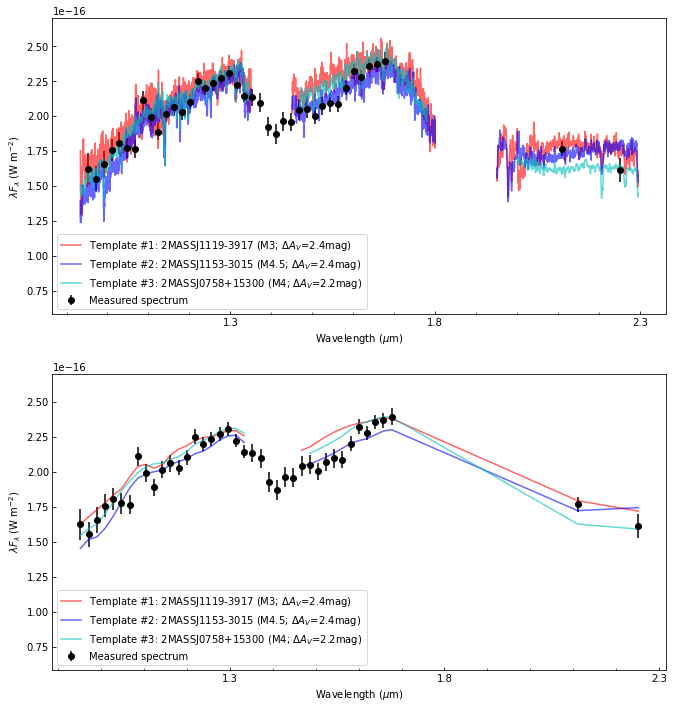

In [145]:
from special.model_resampling import resample_model

# Prepare plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(11,12))

ax1.set_xlabel(r"Wavelength ($\mu$m)")
ax1.set_ylabel("$\lambda F_{\lambda}$ (W m$^{-2}$)")
ax1.set_ylim(0.8*np.amin(lbda*(spec+spec_err)),
             1.1*np.amax(lbda*(spec+spec_err)))

ax2.set_xlabel(r"Wavelength ($\mu$m)")
ax2.set_ylabel("$\lambda F_{\lambda}$ (W m$^{-2}$)")
ax2.set_ylim(0.8*np.amin(lbda*(spec+spec_err)),
             1.1*np.amax(lbda*(spec+spec_err)))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Plot of top 3 spectra:
counter = 0
object_list = []
for ll in range(n_best):
    ## loading
    try:
        _, header = open_fits(inpath_models+final_tmpname[ll],header=True)
        object_list.append(header['OBJECT'])
    except KeyError:
        object_list.append(short_tmpname[ll])
    lbda_tmp, flux_tmp, flux_tmp_err = final_tmp[ll]

    ## cropping range
    try:
        idx_ini = find_nearest(lbda_tmp,0.98*lbda_crop[0], constraint='floor')
    except:
        idx_ini = 0
    try:
        idx_fin = find_nearest(lbda_tmp,1.02*lbda_crop[-1], constraint='ceil')
    except:
        idx_fin = -1
    lbda_tmp_crop = lbda_tmp[idx_ini:idx_fin]
    flux_tmp_crop = flux_tmp[idx_ini:idx_fin]
    dlbda_tmp = np.mean(lbda_tmp_crop[1:]-lbda_tmp_crop[:-1])

    ## Convolving + resampling template spectrum 
    tmp_res = resample_model(lbda_crop, lbda_tmp, flux_tmp, 
                             dlbda_obs=dlbda_crop, 
                             instru_res=instru_res_crop, 
                             instru_idx=instru_idx_crop, 
                             filter_reader=filter_reader)
    lbda_tmp_res, flux_tmp_res = tmp_res
                
    ## formatting labels
    lab_str_list = [labels_tmp[ll]]
    if AV_range is not None:
        lab_str = r'$\Delta A_V$={0:.{1}f}{2}'.format(final_params[1][ll],1,'mag')
        lab_str_list.append(lab_str)
    sep = '; '
    if n_best>1:
        label = "Template #{:.0f}: {} ({})".format(ll+1, short_tmpname[ll], #labels_tmp[ll], 
                                                   sep.join(lab_str_list))
    else:
        label = "Best template: {} ({})".format(short_tmpname[ll], #labels_tmp[ll], 
                                                sep.join(lab_str_list))
        
    ## plotting
    ax1.plot(lbda_tmp_crop, lbda_tmp_crop*flux_tmp_crop, cols[ll+1],
             alpha=0.6, label=label)
    ax2.plot(lbda_tmp_res, lbda_tmp_res*flux_tmp_res, cols[ll+1],
             alpha=0.6, label=label)

    ## ticks
    min_tick = lbda_crop[0]-dlbda_crop[0]/2-((lbda_crop[0]-dlbda_crop[0]/2)%0.2)
    max_tick = lbda_crop[-1]+dlbda_crop[-1]/2+(0.2-((lbda_crop[-1]+dlbda_crop[-1]/2)%0.2))
    major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
    minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

    ax1.set_xticks(major_ticks1)
    ax1.set_xticks(minor_ticks1, minor = True)
    ax1.tick_params(which = 'both', direction = 'in')
    ax2.set_xticks(major_ticks1)
    ax2.set_xticks(minor_ticks1, minor = True)
    ax2.tick_params(which = 'both', direction = 'in')           

# Plot measured spectrum
ax1.errorbar(lbda_crop, lbda_crop*spec_crop, 
             lbda_crop*spec_err_crop, fmt=cols[0]+'o', 
             label='Measured spectrum')
ax1.legend(loc='best')
ax2.errorbar(lbda_crop, lbda_crop*spec_crop, 
             lbda_crop*spec_err_crop, fmt=cols[0]+'o', 
             label='Measured spectrum')
ax2.legend(loc='best')
    
plt.show()

[Go to the top](#Table-of-contents)